### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
#%pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Repo card metadata block was not found. Setting CardData to empty.




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
qqp['test'][0]

{'text1': 'Would the idea of Trump and Putin in bed together scare you, given the geopolitical implications?',
 'text2': 'Do you think that if Donald Trump were elected President, he would be able to restore relations with Putin and Russia as he said he could, based on the rocky relationship Putin had with Obama and Bush?',
 'label': -1,
 'idx': 0,
 'label_text': 'unlabeled'}

In [20]:
qqp['test']

Dataset({
    features: ['text1', 'text2', 'label', 'idx', 'label_text'],
    num_rows: 390965
})

In [4]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

### Tokenize the data

In [5]:
encoding = tokenizer('I want to make sure.','.')

encoding

{'input_ids': [101, 146, 1328, 1106, 1294, 1612, 119, 102, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [3]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = deberta_tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

#qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [17]:
len(qqp_preprocessed['train'])

NameError: name 'qqp_preprocessed' is not defined

In [8]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


In [9]:
qqp['train'][0]

{'text1': 'How is the life of a math student? Could you describe your own experiences?',
 'text2': 'Which level of prepration is enough for the exam jlpt5?',
 'label': 0,
 'idx': 0,
 'label_text': 'not duplicate'}

### Task 1: evaluation (1 points)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [16]:
batch_size = 128

val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, collate_fn=transformers.default_data_collator
)

NameError: name 'qqp_preprocessed' is not defined

In [11]:
qqp_preprocessed

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 390965
    })
})

In [ ]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

In [ ]:
from tqdm import tqdm

accuracy = torch.tensor([0.0], dtype = torch.float64).to(device)

for batch in tqdm(val_loader):
    labels = batch['labels'].to(device)
    with torch.no_grad():
        predicted = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
    
    logits = torch.softmax(predicted.logits, dim = 1).to(device)

    probs = torch.argmax(logits, dim = 1).to(device)

    # print('Labels:', labels)

    # print('Probs:', probs)

    accuracy += torch.sum(labels == probs) / (batch_size * len(val_loader))
    



100%|██████████| 316/316 [01:38<00:00,  3.21it/s]


In [ ]:
accuracy

tensor([0.9080], device='cuda:0', dtype=torch.float64)

In [ ]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (5 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [48]:
# !pip install protobuf
# !pip install sentencepiece
from transformers import AutoModel, AutoModel, AutoConfig, AutoTokenizer
import matplotlib.pyplot as plt
DEBERTA_MODEL_NAME = 'microsoft/deberta-base'
deberta_model = transformers.DebertaForSequenceClassification.from_pretrained(DEBERTA_MODEL_NAME,num_labels = 2)
deberta_tokenizer = transformers.DebertaTokenizerFast.from_pretrained(DEBERTA_MODEL_NAME)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
MAX_LENGTH = 128
def preprocess_function_deberta(examples):
    result = deberta_tokenizer(
        examples['text1'], examples['text2'],
        truncation=True, padding = True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed_new = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [36]:
train_qqp = qqp_preprocessed_new['train'].to_pandas()

test_qqp = qqp_preprocessed_new['validation'].to_pandas()

In [ ]:
input_ids_batch = torch.tensor(train_qqp['input_ids'][0]).unsqueeze(0).to(device)

attention_mask_batch = torch.tensor(train_qqp['attention_mask'][0]).unsqueeze(0).to(device)

In [ ]:
logits = deberta_model(
    input_ids = input_ids_batch,
    attention_mask = attention_mask_batch
).logits

In [37]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_qqp['input_ids']),
    torch.tensor(train_qqp['attention_mask']),
    torch.tensor(train_qqp['label'])
)

eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_qqp['input_ids']),
    torch.tensor(test_qqp['attention_mask']),
    torch.tensor(test_qqp['label'])
)

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 8

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_batch_gen = torch.utils.data.DataLoader(eval_dataset, batch_size = batch_size, shuffle = False)

deberta_model.to(device)

optim = torch.optim.Adam(deberta_model.parameters())

calc_loss = F.cross_entropy

In [89]:
import numpy as np
import time
import tqdm
from IPython.display import clear_output

def eval_model(model, data_generator):
    mse = []
    model.train(False) # disable dropout / use averages for batch_norm

    accuracy = torch.tensor([0.0]).to(device)

    with torch.no_grad():
        for (X_batch_input_ids, X_batch_attention_mask, y_batch) in data_generator:
            X_batch_input_ids = X_batch_input_ids.to(device)
            X_batch_attention_mask = X_batch_attention_mask.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(input_ids = X_batch_input_ids, attention_mask = X_batch_input_ids).logits

            probs = torch.argmax(logits, dim = 1).to(device)

            # print('Labels:', labels)

            # print('Probs:', probs)

            accuracy += torch.sum(y_batch == probs) #/ (y_batch.shape[0] * len(data_generator))

    return accuracy

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch_input_ids, X_batch_attention_mask, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()

        # forward
        X_batch_input_ids = X_batch_input_ids.to(device)
        X_batch_attention_mask = X_batch_attention_mask.to(device)
        y_batch = y_batch.to(device)
        logits = model(input_ids = X_batch_input_ids, attention_mask = X_batch_input_ids).logits
        probs = F.softmax(logits, dim = -1)
        loss = calc_loss(probs, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())

    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    train_loss_arr = []
    val_loss_arr = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_loss = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))

        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss.cpu())
        plt.plot(range(epoch + 1), train_loss_arr, label = 'train')
        plt.plot(range(epoch + 1), val_loss_arr, label = 'val')

100%|██████████| 45481/45481 [2:06:54<00:00,  5.97it/s]  


Epoch 1 of 30 took 8180.880s
  training loss (in-iteration): 	0.682622


100%|██████████| 45481/45481 [2:03:30<00:00,  6.14it/s]  


Epoch 2 of 30 took 7975.941s
  training loss (in-iteration): 	0.682590


 14%|█▍        | 6407/45481 [22:59<2:20:15,  4.64it/s]


KeyboardInterrupt: 

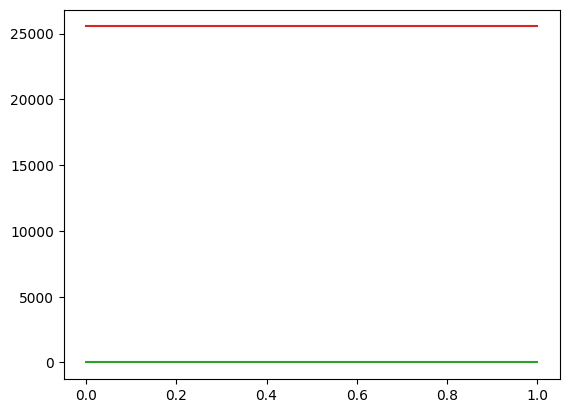

In [90]:
train_loop(deberta_model, optim, train_batch_gen, eval_batch_gen, num_epochs=30)

In [57]:
test_input = torch.tensor([0.0]).to(device)

In [58]:
test_input.cpu()

tensor([0.])

In [96]:
from tqdm import tqdm

accuracy = torch.tensor([0.0], dtype = torch.float64).to(device)

i = 0

with torch.no_grad():
    for (X_batch_input_ids, X_batch_attention_mask, y_batch) in tqdm(eval_batch_gen):
        
        X_batch_input_ids = X_batch_input_ids.to(device)
        X_batch_attention_mask = X_batch_attention_mask.to(device)

        y_batch = y_batch.to(device)

        predicted = deberta_model(
            input_ids=X_batch_input_ids,
            attention_mask=X_batch_attention_mask,
        )

        logits = torch.softmax(predicted.logits, dim = 1).to(device)

        probs = torch.argmax(logits, dim = 1).to(device)

        print('Labels:', y_batch)

        print('Predicted:', probs)

        accuracy += torch.sum(y_batch == probs) / (y_batch.shape[0] * len(eval_batch_gen))
        
        i+=1

        # if i == 100:
        #     break        

print(accuracy)

  0%|          | 1/5054 [00:00<25:54,  3.25it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  0%|          | 3/5054 [00:00<12:59,  6.48it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 6/5054 [00:00<10:09,  8.28it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 8/5054 [00:01<09:27,  8.89it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 10/5054 [00:01<10:00,  8.40it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 12/5054 [00:01<09:38,  8.71it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 14/5054 [00:01<10:05,  8.33it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 15/5054 [00:01<10:05,  8.33it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 18/5054 [00:02<10:04,  8.33it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 20/5054 [00:02<10:31,  7.98it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 22/5054 [00:02<10:31,  7.97it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  0%|          | 24/5054 [00:02<09:56,  8.43it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 26/5054 [00:03<11:51,  7.07it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 28/5054 [00:03<12:05,  6.93it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 31/5054 [00:03<09:39,  8.67it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 32/5054 [00:03<09:46,  8.56it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 34/5054 [00:04<10:34,  7.91it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 36/5054 [00:04<10:24,  8.03it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 38/5054 [00:04<09:27,  8.84it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 40/5054 [00:04<09:12,  9.08it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 42/5054 [00:05<09:32,  8.75it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 44/5054 [00:05<09:23,  8.89it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 47/5054 [00:05<08:51,  9.42it/s]

Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 49/5054 [00:05<09:08,  9.12it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 50/5054 [00:06<09:25,  8.85it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 52/5054 [00:06<09:59,  8.34it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 54/5054 [00:06<09:43,  8.57it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 57/5054 [00:06<09:10,  9.08it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|          | 59/5054 [00:07<08:50,  9.41it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 61/5054 [00:07<08:53,  9.36it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|          | 63/5054 [00:07<09:18,  8.94it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|▏         | 65/5054 [00:07<09:25,  8.83it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|▏         | 67/5054 [00:07<08:52,  9.36it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|▏         | 70/5054 [00:08<08:49,  9.42it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  1%|▏         | 71/5054 [00:08<09:12,  9.02it/s]

Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  1%|▏         | 73/5054 [00:08<09:51,  8.43it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  2%|▏         | 76/5054 [00:08<08:59,  9.23it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  2%|▏         | 77/5054 [00:09<09:00,  9.21it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  2%|▏         | 79/5054 [00:09<09:20,  8.87it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 81/5054 [00:09<09:47,  8.47it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 83/5054 [00:09<09:41,  8.55it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 85/5054 [00:09<09:07,  9.07it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 87/5054 [00:10<09:20,  8.87it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 89/5054 [00:10<08:48,  9.40it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 91/5054 [00:10<09:06,  9.08it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 93/5054 [00:10<08:24,  9.83it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 95/5054 [00:11<08:46,  9.41it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 97/5054 [00:11<08:56,  9.24it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 99/5054 [00:11<08:32,  9.68it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 101/5054 [00:11<08:53,  9.28it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 103/5054 [00:11<09:00,  9.15it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 105/5054 [00:12<08:54,  9.25it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 107/5054 [00:12<09:39,  8.53it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 110/5054 [00:12<08:55,  9.24it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  2%|▏         | 111/5054 [00:12<09:15,  8.91it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 113/5054 [00:13<09:45,  8.43it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 115/5054 [00:13<09:12,  8.94it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 117/5054 [00:13<09:52,  8.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 119/5054 [00:13<09:12,  8.93it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 121/5054 [00:13<09:49,  8.37it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 123/5054 [00:14<09:25,  8.73it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  2%|▏         | 125/5054 [00:14<09:25,  8.72it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 127/5054 [00:14<09:58,  8.24it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 129/5054 [00:14<10:04,  8.15it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 131/5054 [00:15<09:13,  8.90it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 133/5054 [00:15<09:35,  8.56it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 135/5054 [00:15<09:50,  8.33it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 137/5054 [00:15<09:29,  8.64it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 139/5054 [00:16<09:41,  8.45it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 141/5054 [00:16<09:29,  8.62it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 143/5054 [00:16<09:32,  8.58it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 145/5054 [00:16<08:45,  9.34it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 147/5054 [00:16<09:06,  8.97it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 149/5054 [00:17<08:46,  9.31it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 151/5054 [00:17<08:58,  9.11it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 153/5054 [00:17<08:33,  9.54it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 157/5054 [00:17<08:23,  9.72it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 159/5054 [00:18<08:18,  9.81it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 161/5054 [00:18<08:38,  9.43it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 163/5054 [00:18<08:37,  9.46it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 164/5054 [00:18<08:49,  9.24it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 166/5054 [00:19<09:59,  8.15it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 168/5054 [00:19<09:42,  8.39it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  3%|▎         | 170/5054 [00:19<11:22,  7.15it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 172/5054 [00:19<10:04,  8.08it/s]

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 174/5054 [00:19<09:22,  8.68it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  3%|▎         | 175/5054 [00:20<09:04,  8.95it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▎         | 178/5054 [00:20<08:48,  9.23it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▎         | 180/5054 [00:20<08:24,  9.67it/s]

Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▎         | 183/5054 [00:20<08:18,  9.78it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▎         | 185/5054 [00:21<09:07,  8.90it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▎         | 187/5054 [00:21<09:21,  8.67it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▎         | 189/5054 [00:21<09:11,  8.82it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▍         | 191/5054 [00:21<08:25,  9.61it/s]

Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 194/5054 [00:22<08:37,  9.39it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 196/5054 [00:22<09:09,  8.84it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 198/5054 [00:22<09:01,  8.97it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 200/5054 [00:22<09:27,  8.55it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 202/5054 [00:23<09:04,  8.91it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 204/5054 [00:23<09:28,  8.52it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 206/5054 [00:23<08:58,  9.01it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 208/5054 [00:23<09:17,  8.69it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 211/5054 [00:24<08:39,  9.33it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▍         | 213/5054 [00:24<08:51,  9.11it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▍         | 215/5054 [00:24<08:59,  8.97it/s]

Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▍         | 216/5054 [00:24<09:31,  8.47it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 218/5054 [00:24<09:23,  8.58it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 220/5054 [00:25<09:03,  8.89it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 223/5054 [00:25<09:24,  8.56it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  4%|▍         | 224/5054 [00:25<09:26,  8.52it/s]

Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  4%|▍         | 226/5054 [00:25<09:28,  8.50it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 228/5054 [00:25<08:56,  8.99it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 230/5054 [00:26<09:11,  8.75it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 232/5054 [00:26<08:45,  9.18it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 234/5054 [00:26<09:31,  8.43it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 236/5054 [00:26<09:34,  8.39it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 238/5054 [00:27<09:20,  8.60it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 240/5054 [00:27<09:31,  8.43it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 242/5054 [00:27<08:44,  9.17it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 244/5054 [00:27<09:41,  8.28it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 246/5054 [00:28<09:25,  8.50it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▍         | 248/5054 [00:28<08:44,  9.16it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▍         | 252/5054 [00:28<08:10,  9.79it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 254/5054 [00:28<08:29,  9.43it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 256/5054 [00:29<08:40,  9.21it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 258/5054 [00:29<08:45,  9.13it/s]

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 259/5054 [00:29<09:01,  8.86it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 261/5054 [00:29<09:13,  8.65it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 263/5054 [00:29<09:00,  8.87it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 266/5054 [00:30<08:43,  9.14it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 267/5054 [00:30<09:01,  8.84it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▌         | 270/5054 [00:30<08:14,  9.68it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 272/5054 [00:30<08:27,  9.43it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  5%|▌         | 273/5054 [00:31<08:51,  9.00it/s]

Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▌         | 275/5054 [00:31<09:13,  8.64it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  5%|▌         | 277/5054 [00:31<08:47,  9.06it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 279/5054 [00:31<09:40,  8.23it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 281/5054 [00:31<10:00,  7.95it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 283/5054 [00:32<09:23,  8.46it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 285/5054 [00:32<09:22,  8.48it/s]

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 287/5054 [00:32<08:40,  9.17it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▌         | 289/5054 [00:32<08:18,  9.55it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 292/5054 [00:33<08:15,  9.61it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 294/5054 [00:33<08:36,  9.21it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 296/5054 [00:33<08:40,  9.15it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 298/5054 [00:33<08:48,  9.00it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 300/5054 [00:34<09:07,  8.69it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 302/5054 [00:34<09:21,  8.47it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 304/5054 [00:34<08:38,  9.15it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 306/5054 [00:34<08:43,  9.07it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 308/5054 [00:34<08:30,  9.30it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 310/5054 [00:35<08:42,  9.08it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▌         | 312/5054 [00:35<10:03,  7.86it/s]

tensor([1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▌         | 314/5054 [00:35<09:34,  8.25it/s]

Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▋         | 316/5054 [00:35<08:48,  8.97it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▋         | 319/5054 [00:36<08:24,  9.39it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▋         | 321/5054 [00:36<08:27,  9.33it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▋         | 323/5054 [00:36<08:24,  9.37it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▋         | 325/5054 [00:36<08:29,  9.27it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  6%|▋         | 326/5054 [00:36<09:05,  8.66it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  6%|▋         | 328/5054 [00:37<09:07,  8.63it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 330/5054 [00:37<08:31,  9.24it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 332/5054 [00:37<08:35,  9.17it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 334/5054 [00:37<09:15,  8.50it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 336/5054 [00:38<08:57,  8.77it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  7%|▋         | 338/5054 [00:38<08:28,  9.28it/s]

Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 341/5054 [00:38<08:35,  9.14it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  7%|▋         | 343/5054 [00:38<08:27,  9.27it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 345/5054 [00:39<09:14,  8.50it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 347/5054 [00:39<08:52,  8.84it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 349/5054 [00:39<08:36,  9.12it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 351/5054 [00:39<08:46,  8.93it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 353/5054 [00:39<08:42,  9.00it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 355/5054 [00:40<08:12,  9.53it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 357/5054 [00:40<09:04,  8.63it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 359/5054 [00:40<08:22,  9.34it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 361/5054 [00:40<08:51,  8.82it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 363/5054 [00:41<08:45,  8.93it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 365/5054 [00:41<08:49,  8.85it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 367/5054 [00:41<08:17,  9.42it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 369/5054 [00:41<09:01,  8.65it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 371/5054 [00:42<10:20,  7.55it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 373/5054 [00:42<09:34,  8.15it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 375/5054 [00:42<10:26,  7.47it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  7%|▋         | 378/5054 [00:42<08:53,  8.76it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 380/5054 [00:43<08:33,  9.10it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 382/5054 [00:43<08:38,  9.01it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 384/5054 [00:43<08:27,  9.20it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 385/5054 [00:43<08:31,  9.13it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 388/5054 [00:43<08:20,  9.32it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 389/5054 [00:44<08:51,  8.77it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 391/5054 [00:44<09:14,  8.41it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 393/5054 [00:44<09:17,  8.36it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 394/5054 [00:44<08:52,  8.75it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 396/5054 [00:44<10:16,  7.56it/s]

Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 399/5054 [00:45<08:49,  8.79it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 401/5054 [00:45<08:21,  9.28it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 403/5054 [00:45<09:10,  8.45it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 405/5054 [00:46<09:42,  7.98it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 407/5054 [00:46<09:36,  8.06it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 409/5054 [00:46<08:39,  8.94it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 411/5054 [00:46<08:52,  8.71it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 414/5054 [00:46<08:10,  9.46it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 415/5054 [00:47<08:30,  9.09it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 417/5054 [00:47<09:10,  8.43it/s]

tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 420/5054 [00:47<08:18,  9.29it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 421/5054 [00:47<08:36,  8.98it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 424/5054 [00:48<08:58,  8.59it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  8%|▊         | 425/5054 [00:48<09:43,  7.93it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 427/5054 [00:48<09:22,  8.22it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  8%|▊         | 429/5054 [00:48<09:56,  7.75it/s]

tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 431/5054 [00:49<09:18,  8.28it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 433/5054 [00:49<08:51,  8.70it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 435/5054 [00:49<09:17,  8.28it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 437/5054 [00:49<08:54,  8.65it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 439/5054 [00:49<09:09,  8.39it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▊         | 441/5054 [00:50<08:24,  9.14it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 443/5054 [00:50<09:18,  8.25it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  9%|▉         | 446/5054 [00:50<08:46,  8.75it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


  9%|▉         | 447/5054 [00:50<09:21,  8.21it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 449/5054 [00:51<09:56,  7.72it/s]

tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 451/5054 [00:51<09:18,  8.24it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 453/5054 [00:51<08:42,  8.81it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 455/5054 [00:51<09:16,  8.27it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 457/5054 [00:52<09:36,  7.98it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 459/5054 [00:52<09:29,  8.06it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 461/5054 [00:52<09:34,  7.99it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 463/5054 [00:52<08:38,  8.85it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 465/5054 [00:53<09:42,  7.88it/s]

tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 467/5054 [00:53<09:19,  8.20it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 469/5054 [00:53<09:19,  8.20it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 471/5054 [00:53<08:30,  8.97it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 473/5054 [00:54<08:39,  8.81it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 475/5054 [00:54<08:24,  9.08it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 477/5054 [00:54<09:08,  8.34it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

  9%|▉         | 479/5054 [00:54<08:30,  8.96it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 481/5054 [00:54<09:12,  8.27it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 483/5054 [00:55<10:01,  7.61it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 485/5054 [00:55<09:23,  8.10it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 487/5054 [00:55<08:22,  9.09it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 489/5054 [00:55<08:28,  8.98it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 491/5054 [00:56<09:33,  7.96it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 493/5054 [00:56<09:42,  7.83it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 495/5054 [00:56<09:30,  7.99it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 497/5054 [00:56<09:47,  7.76it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 499/5054 [00:57<08:57,  8.48it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|▉         | 502/5054 [00:57<08:48,  8.61it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 10%|▉         | 504/5054 [00:57<08:33,  8.87it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 10%|█         | 506/5054 [00:57<08:34,  8.84it/s]

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 10%|█         | 507/5054 [00:58<08:55,  8.49it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 509/5054 [00:58<08:59,  8.42it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 10%|█         | 511/5054 [00:58<08:07,  9.31it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 514/5054 [00:58<07:58,  9.49it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 516/5054 [00:59<08:51,  8.54it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 518/5054 [00:59<08:48,  8.59it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 520/5054 [00:59<08:19,  9.07it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 522/5054 [00:59<08:14,  9.17it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 524/5054 [00:59<08:22,  9.02it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 526/5054 [01:00<08:38,  8.73it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 528/5054 [01:00<08:52,  8.49it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 10%|█         | 530/5054 [01:00<08:38,  8.72it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 532/5054 [01:00<08:42,  8.66it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 534/5054 [01:01<09:25,  7.99it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 536/5054 [01:01<10:16,  7.33it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 538/5054 [01:01<10:36,  7.09it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 540/5054 [01:02<10:25,  7.22it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 542/5054 [01:02<09:58,  7.54it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 544/5054 [01:02<09:01,  8.33it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 546/5054 [01:02<08:53,  8.44it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 548/5054 [01:02<09:17,  8.09it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 550/5054 [01:03<08:43,  8.60it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 552/5054 [01:03<09:14,  8.12it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 554/5054 [01:03<08:55,  8.40it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 556/5054 [01:03<08:17,  9.03it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 557/5054 [01:04<08:40,  8.65it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 559/5054 [01:04<10:09,  7.37it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 561/5054 [01:04<08:55,  8.40it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 563/5054 [01:04<08:58,  8.34it/s]

tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 565/5054 [01:05<09:27,  7.91it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█         | 567/5054 [01:05<08:55,  8.37it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 569/5054 [01:05<08:25,  8.87it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 571/5054 [01:05<08:28,  8.82it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 573/5054 [01:05<08:29,  8.79it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 575/5054 [01:06<09:29,  7.87it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 577/5054 [01:06<09:25,  7.92it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 579/5054 [01:06<10:50,  6.88it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 11%|█▏        | 581/5054 [01:07<09:47,  7.62it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 583/5054 [01:07<09:00,  8.27it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 585/5054 [01:07<08:39,  8.60it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 587/5054 [01:07<09:24,  7.92it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 589/5054 [01:08<10:19,  7.21it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 12%|█▏        | 591/5054 [01:08<09:20,  7.96it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 12%|█▏        | 593/5054 [01:08<08:44,  8.51it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 12%|█▏        | 594/5054 [01:08<08:34,  8.68it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 595/5054 [01:08<08:45,  8.48it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 598/5054 [01:09<09:18,  7.98it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 600/5054 [01:09<09:11,  8.08it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 602/5054 [01:09<08:37,  8.60it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 604/5054 [01:09<08:26,  8.79it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 606/5054 [01:10<08:20,  8.88it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 608/5054 [01:10<08:29,  8.72it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 610/5054 [01:10<08:22,  8.85it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 612/5054 [01:10<08:17,  8.92it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 614/5054 [01:10<08:07,  9.12it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 616/5054 [01:11<07:36,  9.71it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 618/5054 [01:11<08:15,  8.96it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 620/5054 [01:11<08:16,  8.93it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 622/5054 [01:11<08:24,  8.78it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 624/5054 [01:12<08:15,  8.94it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 626/5054 [01:12<08:40,  8.51it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 628/5054 [01:12<08:37,  8.55it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 12%|█▏        | 630/5054 [01:12<08:01,  9.19it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 632/5054 [01:12<08:16,  8.91it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 634/5054 [01:13<08:01,  9.18it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 636/5054 [01:13<08:46,  8.39it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 638/5054 [01:13<09:25,  7.81it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 640/5054 [01:13<08:46,  8.39it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 642/5054 [01:14<08:18,  8.85it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 644/5054 [01:14<08:53,  8.27it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 646/5054 [01:14<08:42,  8.44it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 649/5054 [01:14<08:09,  9.00it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 13%|█▎        | 650/5054 [01:15<08:22,  8.76it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 652/5054 [01:15<09:09,  8.01it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 654/5054 [01:15<09:35,  7.65it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 656/5054 [01:15<09:40,  7.57it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 658/5054 [01:16<08:43,  8.39it/s]

tensor([1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 661/5054 [01:16<08:34,  8.54it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 13%|█▎        | 663/5054 [01:16<08:06,  9.02it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 665/5054 [01:16<08:27,  8.65it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 667/5054 [01:17<08:19,  8.79it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 668/5054 [01:17<08:49,  8.28it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 671/5054 [01:17<08:30,  8.58it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 673/5054 [01:17<08:38,  8.46it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 675/5054 [01:18<08:18,  8.78it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 677/5054 [01:18<08:49,  8.27it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 679/5054 [01:18<08:40,  8.41it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 13%|█▎        | 681/5054 [01:18<08:09,  8.94it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▎        | 684/5054 [01:19<07:45,  9.39it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▎        | 685/5054 [01:19<08:26,  8.63it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▎        | 687/5054 [01:19<08:31,  8.54it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▎        | 689/5054 [01:19<08:47,  8.28it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▎        | 691/5054 [01:19<08:25,  8.64it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▎        | 693/5054 [01:20<08:11,  8.88it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 695/5054 [01:20<08:56,  8.12it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 696/5054 [01:20<08:43,  8.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 699/5054 [01:20<08:24,  8.62it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 701/5054 [01:21<08:01,  9.03it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 703/5054 [01:21<08:19,  8.71it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 705/5054 [01:21<08:04,  8.97it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 707/5054 [01:21<08:13,  8.80it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 709/5054 [01:22<08:17,  8.74it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 711/5054 [01:22<09:25,  7.68it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▍        | 713/5054 [01:22<08:47,  8.23it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▍        | 715/5054 [01:22<08:14,  8.77it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▍        | 717/5054 [01:22<08:18,  8.70it/s]

Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▍        | 719/5054 [01:23<08:13,  8.78it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 14%|█▍        | 720/5054 [01:23<08:14,  8.77it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: 

 14%|█▍        | 723/5054 [01:23<07:43,  9.34it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 726/5054 [01:23<08:01,  9.00it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 728/5054 [01:24<08:20,  8.64it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 14%|█▍        | 730/5054 [01:24<08:56,  8.05it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 733/5054 [01:24<08:08,  8.85it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 15%|█▍        | 734/5054 [01:24<08:31,  8.44it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 736/5054 [01:25<08:06,  8.88it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 738/5054 [01:25<08:32,  8.43it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 740/5054 [01:25<08:11,  8.79it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 742/5054 [01:25<07:41,  9.33it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 744/5054 [01:26<08:16,  8.69it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 746/5054 [01:26<08:14,  8.71it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 748/5054 [01:26<09:22,  7.66it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 750/5054 [01:26<08:37,  8.32it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 752/5054 [01:27<08:20,  8.60it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 753/5054 [01:27<08:08,  8.80it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 756/5054 [01:27<08:19,  8.61it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▍        | 758/5054 [01:27<08:12,  8.72it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 760/5054 [01:27<08:13,  8.70it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 762/5054 [01:28<08:10,  8.76it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 764/5054 [01:28<08:17,  8.62it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 766/5054 [01:28<09:17,  7.70it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 15%|█▌        | 768/5054 [01:28<08:36,  8.30it/s]

Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 15%|█▌        | 770/5054 [01:29<08:09,  8.76it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 15%|█▌        | 771/5054 [01:29<08:01,  8.90it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 773/5054 [01:29<08:35,  8.30it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 775/5054 [01:29<08:03,  8.84it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 777/5054 [01:29<07:42,  9.24it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 779/5054 [01:30<07:33,  9.42it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 15%|█▌        | 781/5054 [01:30<08:50,  8.05it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 15%|█▌        | 783/5054 [01:30<08:23,  8.48it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 784/5054 [01:30<08:29,  8.38it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 786/5054 [01:30<07:57,  8.94it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 789/5054 [01:31<07:49,  9.09it/s]

Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 791/5054 [01:31<07:58,  8.90it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 793/5054 [01:31<07:45,  9.14it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 795/5054 [01:31<07:46,  9.14it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 796/5054 [01:32<07:35,  9.35it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 798/5054 [01:32<08:59,  7.89it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 800/5054 [01:32<08:20,  8.51it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 801/5054 [01:32<08:40,  8.17it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 804/5054 [01:33<08:03,  8.79it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 806/5054 [01:33<08:12,  8.62it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 808/5054 [01:33<08:15,  8.56it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 810/5054 [01:33<07:56,  8.91it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 812/5054 [01:33<09:04,  7.80it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 814/5054 [01:34<08:30,  8.31it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 16%|█▌        | 815/5054 [01:34<09:04,  7.79it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 817/5054 [01:34<08:23,  8.42it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 819/5054 [01:34<08:21,  8.44it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▌        | 821/5054 [01:35<08:26,  8.36it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 823/5054 [01:35<07:47,  9.04it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 825/5054 [01:35<08:22,  8.42it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 827/5054 [01:35<08:03,  8.74it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 829/5054 [01:35<07:51,  8.95it/s]

tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 831/5054 [01:36<08:46,  8.01it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 16%|█▋        | 833/5054 [01:36<08:51,  7.95it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 835/5054 [01:36<08:55,  7.88it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 837/5054 [01:36<08:20,  8.42it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 839/5054 [01:37<08:37,  8.15it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 841/5054 [01:37<08:55,  7.86it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 843/5054 [01:37<10:12,  6.87it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 17%|█▋        | 844/5054 [01:37<10:08,  6.91it/s]

Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 846/5054 [01:38<09:36,  7.30it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 848/5054 [01:38<09:32,  7.35it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 850/5054 [01:38<09:28,  7.39it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 852/5054 [01:38<09:02,  7.74it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 854/5054 [01:39<09:14,  7.58it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 856/5054 [01:39<09:44,  7.18it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 858/5054 [01:39<08:43,  8.01it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 860/5054 [01:39<08:28,  8.24it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 862/5054 [01:40<08:24,  8.31it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 864/5054 [01:40<08:10,  8.54it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 866/5054 [01:40<09:04,  7.70it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 868/5054 [01:40<08:17,  8.42it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 869/5054 [01:41<08:06,  8.60it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 871/5054 [01:41<09:24,  7.42it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 873/5054 [01:41<08:31,  8.18it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 875/5054 [01:41<07:55,  8.79it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 877/5054 [01:42<07:48,  8.91it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 879/5054 [01:42<07:56,  8.75it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 881/5054 [01:42<08:00,  8.68it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 17%|█▋        | 883/5054 [01:42<09:33,  7.27it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 885/5054 [01:43<08:47,  7.90it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 887/5054 [01:43<08:29,  8.18it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 889/5054 [01:43<07:59,  8.69it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 890/5054 [01:43<08:03,  8.60it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: 

 18%|█▊        | 892/5054 [01:43<08:09,  8.50it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 894/5054 [01:44<08:07,  8.53it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 896/5054 [01:44<09:07,  7.60it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 898/5054 [01:44<08:29,  8.15it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 900/5054 [01:44<08:46,  7.89it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 902/5054 [01:45<08:02,  8.61it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 904/5054 [01:45<08:07,  8.51it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 906/5054 [01:45<08:05,  8.54it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 908/5054 [01:45<08:05,  8.54it/s]

tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 910/5054 [01:46<08:40,  7.96it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 912/5054 [01:46<08:28,  8.15it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 914/5054 [01:46<08:13,  8.39it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 916/5054 [01:46<08:05,  8.53it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 918/5054 [01:46<08:45,  7.87it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 920/5054 [01:47<08:09,  8.45it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 922/5054 [01:47<09:34,  7.19it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 924/5054 [01:47<08:27,  8.14it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 18%|█▊        | 925/5054 [01:47<08:18,  8.29it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 927/5054 [01:48<08:38,  7.96it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 929/5054 [01:48<08:56,  7.69it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 930/5054 [01:48<08:23,  8.18it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 18%|█▊        | 933/5054 [01:48<07:55,  8.66it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 935/5054 [01:49<08:15,  8.31it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 937/5054 [01:49<09:05,  7.54it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 939/5054 [01:49<08:40,  7.90it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 941/5054 [01:49<08:06,  8.46it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 943/5054 [01:50<07:51,  8.72it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 945/5054 [01:50<08:15,  8.28it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▊        | 947/5054 [01:50<08:00,  8.54it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 948/5054 [01:50<07:52,  8.69it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 951/5054 [01:50<08:01,  8.51it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 953/5054 [01:51<08:12,  8.33it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 955/5054 [01:51<08:08,  8.39it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 957/5054 [01:51<07:47,  8.76it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 959/5054 [01:51<07:54,  8.63it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 961/5054 [01:52<09:10,  7.44it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 19%|█▉        | 963/5054 [01:52<08:21,  8.16it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 19%|█▉        | 964/5054 [01:52<08:04,  8.44it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 966/5054 [01:52<07:46,  8.77it/s]

tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 969/5054 [01:53<07:30,  9.08it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 971/5054 [01:53<07:36,  8.94it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 973/5054 [01:53<07:56,  8.56it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 975/5054 [01:53<07:36,  8.93it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 977/5054 [01:54<07:37,  8.92it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 979/5054 [01:54<07:46,  8.74it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 981/5054 [01:54<07:18,  9.29it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 983/5054 [01:54<07:26,  9.11it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 19%|█▉        | 985/5054 [01:54<07:20,  9.24it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 987/5054 [01:55<07:25,  9.14it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 989/5054 [01:55<08:46,  7.72it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 20%|█▉        | 991/5054 [01:55<07:58,  8.49it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 993/5054 [01:55<07:47,  8.70it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 995/5054 [01:56<07:32,  8.96it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 997/5054 [01:56<07:24,  9.13it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 999/5054 [01:56<07:13,  9.36it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 1001/5054 [01:56<07:06,  9.51it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 1003/5054 [01:56<08:28,  7.97it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 20%|█▉        | 1005/5054 [01:57<08:13,  8.21it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 20%|█▉        | 1006/5054 [01:57<08:00,  8.42it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 1008/5054 [01:57<08:02,  8.39it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|█▉        | 1010/5054 [01:57<07:55,  8.50it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1012/5054 [01:58<07:49,  8.61it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1014/5054 [01:58<07:41,  8.75it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1016/5054 [01:58<08:43,  7.72it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1019/5054 [01:58<07:33,  8.90it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 20%|██        | 1020/5054 [01:58<07:53,  8.52it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1022/5054 [01:59<07:36,  8.84it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1024/5054 [01:59<08:14,  8.15it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1026/5054 [01:59<08:18,  8.08it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1028/5054 [02:00<09:25,  7.12it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 20%|██        | 1030/5054 [02:00<08:00,  8.38it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1032/5054 [02:00<08:04,  8.30it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1034/5054 [02:00<07:50,  8.54it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 20%|██        | 1036/5054 [02:00<07:50,  8.53it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1038/5054 [02:01<07:31,  8.90it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1040/5054 [02:01<07:39,  8.74it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1042/5054 [02:01<08:37,  7.75it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1044/5054 [02:01<08:25,  7.93it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1046/5054 [02:02<08:24,  7.94it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1048/5054 [02:02<08:02,  8.30it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1050/5054 [02:02<07:46,  8.59it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1052/5054 [02:02<07:21,  9.07it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1054/5054 [02:03<08:32,  7.80it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1056/5054 [02:03<07:46,  8.57it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1058/5054 [02:03<07:39,  8.69it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1060/5054 [02:03<07:52,  8.45it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1062/5054 [02:03<07:40,  8.66it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1064/5054 [02:04<07:20,  9.05it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1066/5054 [02:04<08:54,  7.47it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1068/5054 [02:04<08:15,  8.05it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1070/5054 [02:04<08:06,  8.20it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██        | 1072/5054 [02:05<08:08,  8.15it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1074/5054 [02:05<08:06,  8.18it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1076/5054 [02:05<07:38,  8.67it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1078/5054 [02:05<08:42,  7.61it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 21%|██▏       | 1079/5054 [02:06<08:30,  7.78it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1081/5054 [02:06<07:54,  8.38it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1083/5054 [02:06<08:12,  8.07it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 21%|██▏       | 1085/5054 [02:06<07:39,  8.64it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1087/5054 [02:07<07:43,  8.56it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1089/5054 [02:07<07:21,  8.98it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1091/5054 [02:07<07:48,  8.47it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1093/5054 [02:07<08:19,  7.94it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1095/5054 [02:08<07:53,  8.36it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1097/5054 [02:08<07:40,  8.59it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1099/5054 [02:08<07:40,  8.60it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1101/5054 [02:08<08:46,  7.51it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1103/5054 [02:09<08:22,  7.87it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1105/5054 [02:09<08:01,  8.21it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 22%|██▏       | 1107/5054 [02:09<07:28,  8.80it/s]

Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 22%|██▏       | 1109/5054 [02:09<07:17,  9.02it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1111/5054 [02:09<07:29,  8.77it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1113/5054 [02:10<08:08,  8.07it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1115/5054 [02:10<07:56,  8.28it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1117/5054 [02:10<07:38,  8.58it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1119/5054 [02:10<08:29,  7.72it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1121/5054 [02:11<08:30,  7.71it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1123/5054 [02:11<08:06,  8.08it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1125/5054 [02:11<08:50,  7.41it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1127/5054 [02:12<09:21,  6.99it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1129/5054 [02:12<09:03,  7.22it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1131/5054 [02:12<08:26,  7.75it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1133/5054 [02:12<08:14,  7.94it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 22%|██▏       | 1135/5054 [02:13<09:12,  7.09it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 22%|██▏       | 1136/5054 [02:13<09:17,  7.02it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1138/5054 [02:13<08:59,  7.26it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1140/5054 [02:13<08:33,  7.62it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1142/5054 [02:13<08:14,  7.91it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1144/5054 [02:14<08:05,  8.05it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1146/5054 [02:14<09:43,  6.70it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 23%|██▎       | 1147/5054 [02:14<09:38,  6.75it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1149/5054 [02:14<08:54,  7.31it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1151/5054 [02:15<08:29,  7.66it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1153/5054 [02:15<08:07,  8.00it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1155/5054 [02:15<07:41,  8.44it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1157/5054 [02:15<08:22,  7.75it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1159/5054 [02:16<07:50,  8.28it/s]

tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1161/5054 [02:16<08:04,  8.04it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1163/5054 [02:16<07:48,  8.30it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1165/5054 [02:16<07:33,  8.58it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1167/5054 [02:17<07:30,  8.63it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1169/5054 [02:17<08:28,  7.65it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1171/5054 [02:17<08:11,  7.90it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1173/5054 [02:17<07:46,  8.32it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1175/5054 [02:18<07:45,  8.33it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1177/5054 [02:18<07:46,  8.31it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1179/5054 [02:18<08:30,  7.58it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1181/5054 [02:18<08:01,  8.04it/s]

tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1183/5054 [02:19<07:46,  8.30it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1185/5054 [02:19<07:56,  8.13it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 23%|██▎       | 1187/5054 [02:19<07:20,  8.77it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1189/5054 [02:19<08:36,  7.48it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 24%|██▎       | 1190/5054 [02:20<08:19,  7.74it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1192/5054 [02:20<08:06,  7.95it/s]

tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1194/5054 [02:20<07:52,  8.16it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1196/5054 [02:20<08:08,  7.89it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1198/5054 [02:21<08:29,  7.57it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▎       | 1200/5054 [02:21<08:41,  7.39it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1202/5054 [02:21<07:49,  8.21it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1204/5054 [02:21<07:28,  8.57it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1206/5054 [02:21<07:29,  8.56it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1208/5054 [02:22<07:47,  8.22it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1210/5054 [02:22<09:06,  7.04it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 24%|██▍       | 1211/5054 [02:22<08:53,  7.20it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1213/5054 [02:22<08:12,  7.79it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1215/5054 [02:23<07:42,  8.31it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1217/5054 [02:23<07:31,  8.50it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1219/5054 [02:23<07:14,  8.83it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1221/5054 [02:23<08:04,  7.92it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1223/5054 [02:24<07:35,  8.40it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1225/5054 [02:24<07:39,  8.32it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1227/5054 [02:24<07:29,  8.52it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1229/5054 [02:24<07:41,  8.29it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1231/5054 [02:25<08:50,  7.21it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 24%|██▍       | 1232/5054 [02:25<08:41,  7.33it/s]

Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1234/5054 [02:25<07:59,  7.96it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1236/5054 [02:25<07:38,  8.32it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 24%|██▍       | 1238/5054 [02:25<07:32,  8.43it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1240/5054 [02:26<07:11,  8.84it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1242/5054 [02:26<08:42,  7.30it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1244/5054 [02:26<07:59,  7.95it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1246/5054 [02:26<07:59,  7.93it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1248/5054 [02:27<08:25,  7.53it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1250/5054 [02:27<09:22,  6.76it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 25%|██▍       | 1252/5054 [02:27<08:13,  7.70it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 25%|██▍       | 1253/5054 [02:27<08:15,  7.67it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1255/5054 [02:28<07:41,  8.23it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1257/5054 [02:28<07:31,  8.42it/s]

tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1259/5054 [02:28<07:30,  8.43it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1261/5054 [02:28<07:08,  8.85it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▍       | 1263/5054 [02:29<08:11,  7.71it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1265/5054 [02:29<07:50,  8.05it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1267/5054 [02:29<07:33,  8.35it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1269/5054 [02:29<07:18,  8.62it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1271/5054 [02:30<08:20,  7.56it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1273/5054 [02:30<07:45,  8.12it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1275/5054 [02:30<07:18,  8.61it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1277/5054 [02:30<07:14,  8.69it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1279/5054 [02:30<07:00,  8.98it/s]

tensor([1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1281/5054 [02:31<08:33,  7.34it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 25%|██▌       | 1283/5054 [02:31<07:43,  8.13it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 25%|██▌       | 1284/5054 [02:31<07:41,  8.18it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1285/5054 [02:31<07:32,  8.32it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 25%|██▌       | 1288/5054 [02:32<07:01,  8.94it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1290/5054 [02:32<07:11,  8.72it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1292/5054 [02:32<07:40,  8.17it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1294/5054 [02:32<07:38,  8.20it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1297/5054 [02:33<06:46,  9.25it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 26%|██▌       | 1298/5054 [02:33<07:17,  8.58it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1300/5054 [02:33<07:16,  8.60it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1302/5054 [02:33<07:53,  7.92it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1304/5054 [02:34<07:44,  8.07it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1306/5054 [02:34<07:08,  8.75it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1308/5054 [02:34<07:03,  8.85it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1310/5054 [02:34<07:01,  8.89it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1312/5054 [02:34<08:07,  7.67it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 26%|██▌       | 1313/5054 [02:35<07:41,  8.10it/s]

Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1315/5054 [02:35<08:11,  7.61it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1317/5054 [02:35<07:34,  8.22it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1319/5054 [02:35<07:39,  8.12it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1321/5054 [02:36<07:49,  7.95it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1323/5054 [02:36<07:33,  8.22it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▌       | 1325/5054 [02:36<07:05,  8.77it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1327/5054 [02:36<07:14,  8.57it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1329/5054 [02:36<07:37,  8.14it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1331/5054 [02:37<07:20,  8.45it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1333/5054 [02:37<07:52,  7.87it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1335/5054 [02:37<07:37,  8.13it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1337/5054 [02:37<07:02,  8.80it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 26%|██▋       | 1339/5054 [02:38<07:03,  8.77it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1341/5054 [02:38<07:02,  8.78it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1342/5054 [02:38<07:23,  8.38it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1345/5054 [02:38<06:59,  8.85it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1347/5054 [02:39<07:24,  8.33it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1349/5054 [02:39<06:55,  8.93it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1351/5054 [02:39<07:00,  8.80it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1353/5054 [02:39<07:41,  8.01it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1355/5054 [02:40<07:06,  8.67it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1357/5054 [02:40<07:28,  8.24it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1359/5054 [02:40<07:05,  8.69it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1361/5054 [02:40<07:13,  8.52it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1363/5054 [02:41<07:59,  7.69it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1365/5054 [02:41<07:20,  8.37it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1367/5054 [02:41<07:24,  8.29it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1369/5054 [02:41<07:14,  8.48it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1371/5054 [02:41<07:26,  8.25it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1373/5054 [02:42<07:48,  7.86it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1375/5054 [02:42<07:25,  8.26it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 27%|██▋       | 1377/5054 [02:42<06:56,  8.83it/s]

Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 27%|██▋       | 1379/5054 [02:42<06:48,  8.99it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1381/5054 [02:43<07:00,  8.74it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 27%|██▋       | 1383/5054 [02:43<08:16,  7.40it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 27%|██▋       | 1385/5054 [02:43<07:35,  8.06it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 27%|██▋       | 1387/5054 [02:43<07:06,  8.59it/s]

Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 27%|██▋       | 1389/5054 [02:44<06:34,  9.29it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1390/5054 [02:44<06:32,  9.35it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1393/5054 [02:44<07:03,  8.65it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1395/5054 [02:44<06:53,  8.84it/s]

tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1397/5054 [02:44<06:41,  9.11it/s]

tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1399/5054 [02:45<06:42,  9.08it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1401/5054 [02:45<06:59,  8.70it/s]

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1403/5054 [02:45<06:48,  8.93it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1405/5054 [02:45<07:05,  8.58it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1407/5054 [02:46<06:55,  8.77it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1409/5054 [02:46<07:04,  8.58it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1411/5054 [02:46<06:47,  8.93it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1412/5054 [02:46<06:35,  9.21it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: 

 28%|██▊       | 1415/5054 [02:46<06:48,  8.91it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1417/5054 [02:47<06:35,  9.21it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1419/5054 [02:47<06:33,  9.24it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1421/5054 [02:47<07:00,  8.64it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1423/5054 [02:47<07:35,  7.98it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1425/5054 [02:48<07:56,  7.62it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1427/5054 [02:48<07:51,  7.70it/s]

tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1429/5054 [02:48<07:23,  8.17it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1431/5054 [02:48<07:05,  8.52it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1433/5054 [02:49<06:54,  8.74it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1435/5054 [02:49<07:41,  7.84it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1437/5054 [02:49<07:13,  8.34it/s]

tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 28%|██▊       | 1439/5054 [02:49<07:10,  8.40it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1441/5054 [02:50<07:14,  8.31it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1443/5054 [02:50<06:57,  8.66it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1445/5054 [02:50<07:32,  7.97it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1447/5054 [02:50<07:11,  8.36it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1449/5054 [02:51<06:54,  8.70it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1451/5054 [02:51<06:35,  9.12it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▊       | 1453/5054 [02:51<07:06,  8.44it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1455/5054 [02:51<07:19,  8.18it/s]

tensor([1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1457/5054 [02:51<07:10,  8.36it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1459/5054 [02:52<07:12,  8.31it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1460/5054 [02:52<07:19,  8.18it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1463/5054 [02:52<06:39,  8.98it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 29%|██▉       | 1465/5054 [02:52<06:19,  9.45it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1467/5054 [02:53<06:47,  8.80it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1469/5054 [02:53<07:10,  8.34it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1472/5054 [02:53<06:35,  9.06it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 29%|██▉       | 1474/5054 [02:53<06:24,  9.32it/s]

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 29%|██▉       | 1475/5054 [02:54<07:15,  8.21it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1477/5054 [02:54<06:47,  8.77it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1479/5054 [02:54<07:01,  8.49it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1481/5054 [02:54<07:12,  8.26it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1483/5054 [02:54<07:02,  8.45it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1485/5054 [02:55<07:09,  8.30it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1487/5054 [02:55<07:01,  8.47it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 29%|██▉       | 1489/5054 [02:55<07:24,  8.01it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1491/5054 [02:55<07:07,  8.33it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 30%|██▉       | 1493/5054 [02:56<06:54,  8.59it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1495/5054 [02:56<06:53,  8.61it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1497/5054 [02:56<06:37,  8.95it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1499/5054 [02:56<07:06,  8.34it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1501/5054 [02:57<07:08,  8.29it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1503/5054 [02:57<07:00,  8.44it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1506/5054 [02:57<06:13,  9.50it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 30%|██▉       | 1508/5054 [02:57<06:19,  9.35it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 30%|██▉       | 1509/5054 [02:57<06:56,  8.50it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1511/5054 [02:58<07:06,  8.31it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1513/5054 [02:58<07:08,  8.27it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|██▉       | 1515/5054 [02:58<06:45,  8.72it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1517/5054 [02:58<06:33,  9.00it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1519/5054 [02:59<07:18,  8.06it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1521/5054 [02:59<07:02,  8.36it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1523/5054 [02:59<06:44,  8.73it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1525/5054 [02:59<06:29,  9.06it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1527/5054 [03:00<06:34,  8.95it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1529/5054 [03:00<07:17,  8.06it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1531/5054 [03:00<06:50,  8.59it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1533/5054 [03:00<06:24,  9.16it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1535/5054 [03:00<06:37,  8.86it/s]

tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1537/5054 [03:01<06:39,  8.80it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1539/5054 [03:01<06:53,  8.50it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 30%|███       | 1541/5054 [03:01<07:00,  8.35it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1543/5054 [03:01<06:55,  8.44it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1545/5054 [03:02<08:06,  7.21it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 31%|███       | 1547/5054 [03:02<07:07,  8.21it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 31%|███       | 1548/5054 [03:02<06:59,  8.36it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1550/5054 [03:02<07:05,  8.23it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1552/5054 [03:03<06:56,  8.41it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1554/5054 [03:03<07:18,  7.98it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1556/5054 [03:03<06:41,  8.71it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1558/5054 [03:03<06:29,  8.97it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1560/5054 [03:03<06:57,  8.37it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1562/5054 [03:04<07:13,  8.06it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1564/5054 [03:04<07:36,  7.64it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1566/5054 [03:04<07:18,  7.96it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1567/5054 [03:04<07:18,  7.95it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 31%|███       | 1571/5054 [03:05<06:33,  8.85it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 31%|███       | 1572/5054 [03:05<06:53,  8.41it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1574/5054 [03:05<07:03,  8.21it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1576/5054 [03:05<06:59,  8.28it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███       | 1579/5054 [03:06<06:12,  9.33it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 31%|███▏      | 1580/5054 [03:06<07:01,  8.24it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1582/5054 [03:06<07:00,  8.25it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1584/5054 [03:06<07:17,  7.93it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1586/5054 [03:07<06:48,  8.49it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1588/5054 [03:07<06:44,  8.57it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1590/5054 [03:07<07:13,  7.99it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 31%|███▏      | 1592/5054 [03:07<06:54,  8.34it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1594/5054 [03:08<07:23,  7.80it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1596/5054 [03:08<06:52,  8.39it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1598/5054 [03:08<07:24,  7.77it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1600/5054 [03:08<06:41,  8.61it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1602/5054 [03:09<07:08,  8.05it/s]

tensor([1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1604/5054 [03:09<06:49,  8.43it/s]

tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1606/5054 [03:09<07:13,  7.95it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1608/5054 [03:09<06:55,  8.29it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1610/5054 [03:10<06:30,  8.81it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1612/5054 [03:10<06:19,  9.07it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1614/5054 [03:10<06:22,  8.98it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1616/5054 [03:10<07:05,  8.08it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1618/5054 [03:10<07:01,  8.15it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1620/5054 [03:11<06:43,  8.51it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1622/5054 [03:11<06:48,  8.40it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1624/5054 [03:11<06:24,  8.93it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1626/5054 [03:11<07:04,  8.08it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1628/5054 [03:12<06:59,  8.16it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1630/5054 [03:12<06:28,  8.81it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 32%|███▏      | 1633/5054 [03:12<06:06,  9.33it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 32%|███▏      | 1634/5054 [03:12<06:01,  9.47it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1636/5054 [03:13<06:48,  8.37it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1638/5054 [03:13<07:18,  7.79it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1640/5054 [03:13<07:01,  8.10it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 32%|███▏      | 1642/5054 [03:13<06:40,  8.53it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1644/5054 [03:14<07:19,  7.77it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1646/5054 [03:14<06:39,  8.52it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1648/5054 [03:14<06:36,  8.60it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1650/5054 [03:14<06:43,  8.43it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1652/5054 [03:15<07:32,  7.51it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1654/5054 [03:15<06:50,  8.29it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1655/5054 [03:15<07:16,  7.79it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1657/5054 [03:15<06:53,  8.21it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1659/5054 [03:15<06:55,  8.18it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1661/5054 [03:16<07:07,  7.93it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1664/5054 [03:16<06:20,  8.91it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1665/5054 [03:16<06:27,  8.75it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1667/5054 [03:16<06:10,  9.14it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1669/5054 [03:17<06:38,  8.50it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1672/5054 [03:17<06:22,  8.84it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1674/5054 [03:17<06:20,  8.88it/s]

Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1675/5054 [03:17<06:31,  8.62it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1677/5054 [03:17<06:24,  8.79it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1679/5054 [03:18<07:21,  7.64it/s]

tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1681/5054 [03:18<06:40,  8.42it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 33%|███▎      | 1683/5054 [03:18<06:09,  9.11it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1685/5054 [03:18<06:19,  8.88it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1687/5054 [03:19<06:52,  8.17it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1689/5054 [03:19<06:34,  8.53it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1691/5054 [03:19<06:53,  8.14it/s]

tensor([1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 33%|███▎      | 1693/5054 [03:19<06:49,  8.20it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▎      | 1695/5054 [03:20<06:48,  8.22it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▎      | 1697/5054 [03:20<07:10,  7.79it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▎      | 1700/5054 [03:20<06:10,  9.05it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 34%|███▎      | 1701/5054 [03:20<06:04,  9.20it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▎      | 1704/5054 [03:21<06:38,  8.42it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1706/5054 [03:21<06:46,  8.25it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1708/5054 [03:21<06:24,  8.71it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1710/5054 [03:21<06:45,  8.25it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1713/5054 [03:22<06:02,  9.22it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 34%|███▍      | 1714/5054 [03:22<06:44,  8.25it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1716/5054 [03:22<06:44,  8.26it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1718/5054 [03:22<06:21,  8.74it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1720/5054 [03:22<06:34,  8.44it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1722/5054 [03:23<06:25,  8.65it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1724/5054 [03:23<06:46,  8.20it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1726/5054 [03:23<06:19,  8.77it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1728/5054 [03:23<06:32,  8.48it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1730/5054 [03:24<06:19,  8.76it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1732/5054 [03:24<06:53,  8.03it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1734/5054 [03:24<06:30,  8.51it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1736/5054 [03:24<06:08,  9.00it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1738/5054 [03:25<06:57,  7.94it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1739/5054 [03:25<06:55,  7.98it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 34%|███▍      | 1742/5054 [03:25<06:31,  8.47it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1744/5054 [03:25<06:39,  8.28it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1745/5054 [03:25<07:01,  7.85it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1748/5054 [03:26<06:48,  8.09it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1750/5054 [03:26<06:37,  8.31it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1752/5054 [03:26<06:23,  8.62it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1754/5054 [03:27<07:19,  7.51it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 35%|███▍      | 1755/5054 [03:27<06:57,  7.91it/s]

Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1757/5054 [03:27<06:55,  7.94it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1759/5054 [03:27<06:35,  8.34it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1761/5054 [03:27<07:01,  7.81it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1763/5054 [03:28<06:58,  7.87it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1765/5054 [03:28<06:24,  8.56it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▍      | 1767/5054 [03:28<06:25,  8.52it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1769/5054 [03:28<07:04,  7.73it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1771/5054 [03:29<06:35,  8.29it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1773/5054 [03:29<06:47,  8.05it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1775/5054 [03:29<06:06,  8.95it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: 

 35%|███▌      | 1777/5054 [03:29<06:08,  8.89it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1779/5054 [03:30<06:23,  8.53it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1781/5054 [03:30<06:32,  8.33it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1783/5054 [03:30<06:01,  9.04it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1785/5054 [03:30<05:56,  9.17it/s]

tensor([1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1787/5054 [03:31<06:42,  8.11it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1789/5054 [03:31<06:36,  8.24it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1791/5054 [03:31<06:32,  8.30it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 35%|███▌      | 1793/5054 [03:31<06:11,  8.78it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1795/5054 [03:31<06:29,  8.36it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1797/5054 [03:32<06:57,  7.81it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1799/5054 [03:32<06:28,  8.39it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1802/5054 [03:32<06:09,  8.81it/s]

Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1803/5054 [03:32<06:22,  8.49it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1805/5054 [03:33<06:15,  8.66it/s]

Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1807/5054 [03:33<06:51,  7.88it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1809/5054 [03:33<06:30,  8.32it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1811/5054 [03:33<05:58,  9.05it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1813/5054 [03:34<06:34,  8.21it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1815/5054 [03:34<06:36,  8.17it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1817/5054 [03:34<06:32,  8.26it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1819/5054 [03:34<07:16,  7.42it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1821/5054 [03:35<06:33,  8.21it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1823/5054 [03:35<06:12,  8.68it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▌      | 1824/5054 [03:35<06:21,  8.46it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1826/5054 [03:35<06:18,  8.53it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1828/5054 [03:35<06:34,  8.18it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1830/5054 [03:36<06:15,  8.59it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▌      | 1832/5054 [03:36<07:07,  7.54it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▋      | 1833/5054 [03:36<06:42,  8.00it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▋      | 1835/5054 [03:36<06:59,  7.68it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▋      | 1837/5054 [03:37<06:40,  8.03it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▋      | 1840/5054 [03:37<05:52,  9.11it/s]

Labels: tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 36%|███▋      | 1841/5054 [03:37<06:06,  8.77it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 36%|███▋      | 1843/5054 [03:37<06:30,  8.22it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1845/5054 [03:37<06:32,  8.17it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1847/5054 [03:38<06:50,  7.81it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 37%|███▋      | 1848/5054 [03:38<06:54,  7.74it/s]

Labels: tensor([1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1850/5054 [03:38<06:52,  7.76it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1852/5054 [03:38<06:57,  7.66it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1854/5054 [03:39<06:32,  8.14it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1856/5054 [03:39<06:33,  8.13it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1858/5054 [03:39<06:13,  8.56it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1860/5054 [03:39<05:59,  8.89it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1862/5054 [03:40<06:40,  7.98it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1864/5054 [03:40<06:18,  8.44it/s]

tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1866/5054 [03:40<06:05,  8.71it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1868/5054 [03:40<06:11,  8.57it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1870/5054 [03:41<07:05,  7.48it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 37%|███▋      | 1871/5054 [03:41<07:01,  7.55it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1873/5054 [03:41<06:36,  8.02it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1875/5054 [03:41<06:33,  8.08it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1877/5054 [03:41<06:26,  8.21it/s]

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1879/5054 [03:42<06:55,  7.65it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1881/5054 [03:42<06:25,  8.23it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1883/5054 [03:42<06:15,  8.45it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1885/5054 [03:42<06:29,  8.14it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1887/5054 [03:43<06:10,  8.54it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1889/5054 [03:43<06:01,  8.75it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1891/5054 [03:43<05:56,  8.87it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1893/5054 [03:43<06:33,  8.04it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 37%|███▋      | 1895/5054 [03:44<06:09,  8.55it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1897/5054 [03:44<06:17,  8.37it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1899/5054 [03:44<06:08,  8.57it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1901/5054 [03:44<07:06,  7.40it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 38%|███▊      | 1903/5054 [03:45<06:27,  8.13it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 38%|███▊      | 1904/5054 [03:45<06:25,  8.18it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1906/5054 [03:45<06:45,  7.77it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1908/5054 [03:45<06:56,  7.55it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1910/5054 [03:45<06:17,  8.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1912/5054 [03:46<05:51,  8.93it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1914/5054 [03:46<06:09,  8.49it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1916/5054 [03:46<06:20,  8.24it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1918/5054 [03:46<06:29,  8.05it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1920/5054 [03:47<06:16,  8.33it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1922/5054 [03:47<06:49,  7.66it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1924/5054 [03:47<06:18,  8.27it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1926/5054 [03:47<06:08,  8.49it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1928/5054 [03:48<06:23,  8.15it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1930/5054 [03:48<06:05,  8.56it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 38%|███▊      | 1933/5054 [03:48<05:36,  9.29it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1935/5054 [03:48<05:40,  9.16it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1937/5054 [03:49<06:18,  8.24it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1939/5054 [03:49<06:16,  8.26it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 38%|███▊      | 1941/5054 [03:49<05:52,  8.83it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1943/5054 [03:49<05:53,  8.79it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 38%|███▊      | 1945/5054 [03:50<05:45,  9.00it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▊      | 1947/5054 [03:50<06:49,  7.60it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 39%|███▊      | 1949/5054 [03:50<06:20,  8.17it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 39%|███▊      | 1950/5054 [03:50<06:22,  8.12it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▊      | 1952/5054 [03:50<06:42,  7.71it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▊      | 1954/5054 [03:51<07:05,  7.28it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▊      | 1956/5054 [03:51<06:58,  7.41it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▊      | 1958/5054 [03:51<06:18,  8.19it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1960/5054 [03:51<05:50,  8.82it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1962/5054 [03:52<06:33,  7.86it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1964/5054 [03:52<06:16,  8.21it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1966/5054 [03:52<06:25,  8.02it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1968/5054 [03:52<06:08,  8.38it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1970/5054 [03:53<07:08,  7.20it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 39%|███▉      | 1972/5054 [03:53<06:18,  8.15it/s]

Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 39%|███▉      | 1973/5054 [03:53<06:17,  8.15it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1975/5054 [03:53<06:33,  7.82it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1977/5054 [03:54<07:02,  7.29it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1979/5054 [03:54<06:23,  8.02it/s]

tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1981/5054 [03:54<06:22,  8.03it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1983/5054 [03:54<05:44,  8.91it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1985/5054 [03:55<05:54,  8.65it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1987/5054 [03:55<05:45,  8.89it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1989/5054 [03:55<05:52,  8.71it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1991/5054 [03:55<05:44,  8.89it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1993/5054 [03:55<06:31,  7.81it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 39%|███▉      | 1995/5054 [03:56<06:28,  7.87it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 1997/5054 [03:56<05:58,  8.52it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2000/5054 [03:56<05:14,  9.70it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|███▉      | 2001/5054 [03:56<05:54,  8.62it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2003/5054 [03:57<05:54,  8.62it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2005/5054 [03:57<05:56,  8.54it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2007/5054 [03:57<07:15,  7.00it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2009/5054 [03:57<06:23,  7.93it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|███▉      | 2011/5054 [03:58<06:02,  8.39it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2013/5054 [03:58<06:12,  8.16it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2015/5054 [03:58<06:14,  8.11it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2017/5054 [03:58<05:42,  8.86it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2019/5054 [03:59<06:02,  8.38it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|███▉      | 2021/5054 [03:59<05:41,  8.88it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2023/5054 [03:59<06:34,  7.68it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|████      | 2024/5054 [03:59<06:27,  7.83it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2026/5054 [03:59<06:17,  8.02it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2028/5054 [04:00<06:18,  7.99it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2030/5054 [04:00<06:11,  8.13it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2032/5054 [04:00<06:42,  7.50it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2034/5054 [04:01<06:34,  7.65it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2036/5054 [04:01<06:02,  8.32it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2038/5054 [04:01<06:48,  7.39it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|████      | 2040/5054 [04:01<06:12,  8.10it/s]

Labels: tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|████      | 2042/5054 [04:01<05:57,  8.44it/s]

Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 40%|████      | 2043/5054 [04:02<05:59,  8.36it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 40%|████      | 2045/5054 [04:02<07:01,  7.14it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████      | 2047/5054 [04:02<06:08,  8.17it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████      | 2049/5054 [04:02<05:52,  8.52it/s]

Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████      | 2050/5054 [04:02<06:07,  8.17it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2052/5054 [04:03<06:46,  7.39it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2054/5054 [04:03<06:10,  8.09it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2056/5054 [04:03<05:43,  8.72it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2058/5054 [04:03<05:35,  8.94it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2060/5054 [04:04<05:49,  8.57it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2062/5054 [04:04<06:19,  7.89it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2064/5054 [04:04<06:14,  7.98it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2066/5054 [04:04<06:37,  7.52it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2068/5054 [04:05<05:58,  8.32it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2070/5054 [04:05<06:43,  7.40it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████      | 2071/5054 [04:05<06:30,  7.64it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2073/5054 [04:05<07:26,  6.67it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████      | 2074/5054 [04:05<06:52,  7.23it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2076/5054 [04:06<06:20,  7.83it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2078/5054 [04:06<06:07,  8.11it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2080/5054 [04:06<06:36,  7.49it/s]

tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2082/5054 [04:07<06:26,  7.69it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████      | 2084/5054 [04:07<06:03,  8.18it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2086/5054 [04:07<05:39,  8.74it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2088/5054 [04:07<06:05,  8.11it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2090/5054 [04:07<05:34,  8.86it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2092/5054 [04:08<05:50,  8.44it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2094/5054 [04:08<05:38,  8.75it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 41%|████▏     | 2096/5054 [04:08<06:26,  7.66it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 41%|████▏     | 2097/5054 [04:08<06:27,  7.63it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2099/5054 [04:09<06:09,  8.01it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2101/5054 [04:09<06:29,  7.58it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2103/5054 [04:09<06:09,  7.98it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2105/5054 [04:09<05:41,  8.63it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2107/5054 [04:09<05:27,  9.00it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2109/5054 [04:10<06:23,  7.67it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2111/5054 [04:10<05:59,  8.18it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2113/5054 [04:10<06:03,  8.08it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2115/5054 [04:10<05:47,  8.46it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2117/5054 [04:11<06:37,  7.39it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2119/5054 [04:11<05:57,  8.21it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2120/5054 [04:11<05:58,  8.18it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2123/5054 [04:12<06:02,  8.08it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2125/5054 [04:12<05:51,  8.34it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2127/5054 [04:12<06:18,  7.73it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2129/5054 [04:12<06:27,  7.54it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2131/5054 [04:13<06:12,  7.84it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2133/5054 [04:13<06:05,  8.00it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2135/5054 [04:13<05:43,  8.51it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2137/5054 [04:13<06:14,  7.79it/s]

tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2139/5054 [04:14<06:01,  8.07it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2141/5054 [04:14<06:22,  7.62it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2142/5054 [04:14<06:16,  7.73it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2145/5054 [04:14<05:42,  8.48it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 42%|████▏     | 2147/5054 [04:14<05:35,  8.67it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2149/5054 [04:15<06:34,  7.37it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 43%|████▎     | 2150/5054 [04:15<06:19,  7.65it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2152/5054 [04:15<05:47,  8.35it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2154/5054 [04:15<05:41,  8.50it/s]

tensor([1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2156/5054 [04:16<05:46,  8.37it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2158/5054 [04:16<05:39,  8.52it/s]

tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2160/5054 [04:16<05:36,  8.61it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2162/5054 [04:16<05:38,  8.55it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2164/5054 [04:17<06:07,  7.87it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2166/5054 [04:17<06:13,  7.74it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2168/5054 [04:17<06:01,  7.99it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2170/5054 [04:17<05:57,  8.06it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2172/5054 [04:18<06:08,  7.81it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2174/5054 [04:18<06:14,  7.70it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2176/5054 [04:18<06:00,  7.98it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2178/5054 [04:18<05:36,  8.55it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2180/5054 [04:19<06:09,  7.78it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2182/5054 [04:19<05:45,  8.31it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2184/5054 [04:19<05:51,  8.17it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2186/5054 [04:19<05:39,  8.46it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2188/5054 [04:19<05:12,  9.19it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2190/5054 [04:20<05:09,  9.26it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2191/5054 [04:20<05:19,  8.97it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2193/5054 [04:20<06:45,  7.05it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2195/5054 [04:20<06:24,  7.43it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 43%|████▎     | 2197/5054 [04:21<06:23,  7.44it/s]

tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2199/5054 [04:21<06:39,  7.15it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2201/5054 [04:21<06:32,  7.27it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2203/5054 [04:21<06:00,  7.90it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2205/5054 [04:22<06:17,  7.55it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2207/5054 [04:22<05:36,  8.46it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 44%|████▎     | 2209/5054 [04:22<05:23,  8.79it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▎     | 2211/5054 [04:22<06:19,  7.50it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 44%|████▍     | 2213/5054 [04:23<05:41,  8.31it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 44%|████▍     | 2214/5054 [04:23<05:38,  8.40it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2216/5054 [04:23<06:22,  7.41it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2218/5054 [04:23<06:10,  7.65it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2220/5054 [04:24<05:32,  8.53it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2222/5054 [04:24<05:20,  8.85it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2224/5054 [04:24<05:32,  8.50it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2226/5054 [04:24<05:40,  8.31it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2228/5054 [04:24<05:47,  8.13it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2230/5054 [04:25<05:32,  8.50it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2232/5054 [04:25<05:52,  8.01it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2234/5054 [04:25<05:24,  8.70it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2236/5054 [04:25<05:51,  8.01it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2238/5054 [04:26<05:30,  8.52it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: 

 44%|████▍     | 2240/5054 [04:26<05:18,  8.85it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2242/5054 [04:26<06:01,  7.77it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 44%|████▍     | 2243/5054 [04:26<05:55,  7.90it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2245/5054 [04:27<06:12,  7.55it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2247/5054 [04:27<05:42,  8.21it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 44%|████▍     | 2249/5054 [04:27<06:29,  7.21it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 45%|████▍     | 2251/5054 [04:27<05:39,  8.26it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 45%|████▍     | 2252/5054 [04:27<05:40,  8.22it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2254/5054 [04:28<05:49,  8.01it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2256/5054 [04:28<05:36,  8.32it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 45%|████▍     | 2258/5054 [04:28<05:13,  8.91it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2260/5054 [04:28<05:49,  7.99it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2262/5054 [04:29<06:01,  7.72it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2264/5054 [04:29<05:58,  7.78it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2266/5054 [04:29<06:04,  7.64it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2268/5054 [04:29<05:49,  7.97it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2270/5054 [04:30<05:29,  8.46it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▍     | 2272/5054 [04:30<06:21,  7.29it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 45%|████▍     | 2273/5054 [04:30<06:13,  7.44it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2275/5054 [04:30<06:35,  7.03it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 45%|████▌     | 2276/5054 [04:31<06:42,  6.91it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2278/5054 [04:31<06:17,  7.34it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2280/5054 [04:31<06:15,  7.39it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2282/5054 [04:31<05:52,  7.87it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2284/5054 [04:31<05:43,  8.06it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2286/5054 [04:32<05:06,  9.03it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2288/5054 [04:32<05:31,  8.35it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2290/5054 [04:32<05:57,  7.73it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2292/5054 [04:32<05:39,  8.14it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2294/5054 [04:33<05:27,  8.42it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2296/5054 [04:33<06:07,  7.50it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 45%|████▌     | 2298/5054 [04:33<06:01,  7.63it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2300/5054 [04:33<05:51,  7.84it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2302/5054 [04:34<05:35,  8.21it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2304/5054 [04:34<05:31,  8.30it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2306/5054 [04:34<05:04,  9.04it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2308/5054 [04:34<05:35,  8.18it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2310/5054 [04:35<05:19,  8.60it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2312/5054 [04:35<05:32,  8.24it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2314/5054 [04:35<05:45,  7.92it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2316/5054 [04:35<05:08,  8.86it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: 

 46%|████▌     | 2318/5054 [04:36<05:02,  9.03it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2320/5054 [04:36<05:35,  8.15it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2322/5054 [04:36<05:59,  7.59it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2324/5054 [04:36<05:34,  8.16it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: 

 46%|████▌     | 2326/5054 [04:37<05:07,  8.87it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2328/5054 [04:37<05:52,  7.73it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 46%|████▌     | 2329/5054 [04:37<05:45,  7.89it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2331/5054 [04:37<05:44,  7.90it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2333/5054 [04:37<06:01,  7.52it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2335/5054 [04:38<05:49,  7.78it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▌     | 2337/5054 [04:38<05:21,  8.45it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2339/5054 [04:38<05:17,  8.56it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2341/5054 [04:38<05:37,  8.03it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2343/5054 [04:39<05:32,  8.16it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2345/5054 [04:39<05:57,  7.59it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 46%|████▋     | 2346/5054 [04:39<06:12,  7.28it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2348/5054 [04:39<06:57,  6.49it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 46%|████▋     | 2350/5054 [04:40<06:39,  6.77it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2352/5054 [04:40<06:01,  7.47it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2354/5054 [04:40<05:42,  7.89it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2356/5054 [04:40<05:35,  8.04it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2358/5054 [04:41<05:34,  8.06it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2360/5054 [04:41<05:42,  7.87it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2362/5054 [04:41<05:28,  8.19it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2364/5054 [04:41<06:04,  7.37it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2366/5054 [04:42<05:40,  7.89it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2368/5054 [04:42<06:26,  6.94it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 47%|████▋     | 2369/5054 [04:42<05:57,  7.51it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2371/5054 [04:42<05:35,  8.01it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2373/5054 [04:43<05:42,  7.82it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2375/5054 [04:43<06:14,  7.16it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 47%|████▋     | 2377/5054 [04:43<05:32,  8.04it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 47%|████▋     | 2378/5054 [04:43<05:42,  7.82it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2380/5054 [04:44<05:36,  7.94it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2382/5054 [04:44<05:37,  7.92it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2384/5054 [04:44<05:28,  8.13it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2386/5054 [04:44<05:23,  8.26it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2388/5054 [04:45<05:53,  7.54it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2390/5054 [04:45<05:52,  7.55it/s]

tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2392/5054 [04:45<05:55,  7.49it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2394/5054 [04:45<05:49,  7.60it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2396/5054 [04:46<06:06,  7.25it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 47%|████▋     | 2398/5054 [04:46<05:34,  7.93it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: 

 47%|████▋     | 2400/5054 [04:46<05:01,  8.82it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2402/5054 [04:46<05:28,  8.07it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2404/5054 [04:47<05:39,  7.81it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2406/5054 [04:47<05:17,  8.34it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2408/5054 [04:47<05:45,  7.65it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2410/5054 [04:47<05:32,  7.95it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2412/5054 [04:48<06:03,  7.26it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 48%|████▊     | 2414/5054 [04:48<05:28,  8.03it/s]

Labels: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 48%|████▊     | 2415/5054 [04:48<05:17,  8.32it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2417/5054 [04:48<05:44,  7.66it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2419/5054 [04:49<05:44,  7.65it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2421/5054 [04:49<05:41,  7.70it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2423/5054 [04:49<05:30,  7.95it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2425/5054 [04:49<05:16,  8.30it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2427/5054 [04:50<05:49,  7.52it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2429/5054 [04:50<05:42,  7.67it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2431/5054 [04:50<05:48,  7.52it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2433/5054 [04:50<05:35,  7.82it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2435/5054 [04:51<05:51,  7.46it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2437/5054 [04:51<05:41,  7.67it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2439/5054 [04:51<05:45,  7.57it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 48%|████▊     | 2441/5054 [04:51<05:02,  8.63it/s]

Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2443/5054 [04:52<05:09,  8.45it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2444/5054 [04:52<04:59,  8.71it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2446/5054 [04:52<06:02,  7.20it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2448/5054 [04:52<05:32,  7.83it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 48%|████▊     | 2450/5054 [04:52<05:14,  8.27it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▊     | 2452/5054 [04:53<05:18,  8.16it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▊     | 2454/5054 [04:53<05:08,  8.43it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▊     | 2456/5054 [04:53<05:51,  7.39it/s]

tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 49%|████▊     | 2457/5054 [04:53<05:28,  7.91it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▊     | 2459/5054 [04:54<05:15,  8.23it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▊     | 2461/5054 [04:54<06:02,  7.15it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 49%|████▊     | 2463/5054 [04:54<05:26,  7.93it/s]

Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 49%|████▉     | 2464/5054 [04:54<05:08,  8.40it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2466/5054 [04:54<05:42,  7.55it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2468/5054 [04:55<05:22,  8.03it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2470/5054 [04:55<05:07,  8.39it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2472/5054 [04:55<05:29,  7.83it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2474/5054 [04:55<05:37,  7.64it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2476/5054 [04:56<05:39,  7.59it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2478/5054 [04:56<05:30,  7.79it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2480/5054 [04:56<05:09,  8.31it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2482/5054 [04:56<05:19,  8.06it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2485/5054 [04:57<04:43,  9.06it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 49%|████▉     | 2486/5054 [04:57<04:55,  8.68it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2488/5054 [04:57<05:05,  8.40it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2490/5054 [04:57<05:28,  7.80it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2492/5054 [04:58<05:05,  8.39it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2494/5054 [04:58<05:47,  7.37it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 49%|████▉     | 2495/5054 [04:58<05:40,  7.51it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2497/5054 [04:58<05:35,  7.62it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2499/5054 [04:59<05:30,  7.73it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 49%|████▉     | 2501/5054 [04:59<05:29,  7.74it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2503/5054 [04:59<05:04,  8.38it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2505/5054 [04:59<04:45,  8.93it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2508/5054 [05:00<04:51,  8.73it/s]

tensor([1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|████▉     | 2510/5054 [05:00<04:49,  8.78it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|████▉     | 2511/5054 [05:00<04:46,  8.88it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2513/5054 [05:00<05:24,  7.82it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2515/5054 [05:01<05:11,  8.14it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2517/5054 [05:01<05:03,  8.35it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2519/5054 [05:01<05:26,  7.77it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2521/5054 [05:01<04:58,  8.48it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|████▉     | 2523/5054 [05:02<05:41,  7.42it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|████▉     | 2525/5054 [05:02<05:18,  7.93it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|████▉     | 2526/5054 [05:02<05:17,  7.97it/s]

Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|█████     | 2528/5054 [05:02<04:53,  8.60it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2530/5054 [05:02<05:15,  8.00it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2532/5054 [05:03<04:52,  8.61it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2534/5054 [05:03<04:58,  8.43it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2537/5054 [05:03<04:40,  8.99it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 50%|█████     | 2538/5054 [05:03<04:41,  8.94it/s]

Labels: tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2540/5054 [05:04<05:12,  8.05it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2542/5054 [05:04<05:14,  7.98it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2544/5054 [05:04<05:22,  7.79it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2546/5054 [05:04<04:59,  8.37it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2548/5054 [05:05<05:07,  8.15it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2550/5054 [05:05<05:29,  7.61it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 50%|█████     | 2552/5054 [05:05<05:05,  8.19it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2554/5054 [05:05<04:43,  8.80it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 51%|█████     | 2556/5054 [05:05<04:32,  9.15it/s]

Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2558/5054 [05:06<04:55,  8.46it/s]

tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2560/5054 [05:06<04:54,  8.47it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2562/5054 [05:06<05:13,  7.95it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2564/5054 [05:06<05:13,  7.94it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2566/5054 [05:07<05:35,  7.42it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2567/5054 [05:07<05:33,  7.47it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2570/5054 [05:07<05:31,  7.50it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2572/5054 [05:07<05:00,  8.25it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 51%|█████     | 2574/5054 [05:08<04:40,  8.85it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2576/5054 [05:08<05:03,  8.17it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2578/5054 [05:08<04:50,  8.54it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2580/5054 [05:08<04:54,  8.40it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2582/5054 [05:09<05:31,  7.46it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2584/5054 [05:09<05:55,  6.94it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2586/5054 [05:09<05:33,  7.41it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2588/5054 [05:10<04:53,  8.39it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████     | 2590/5054 [05:10<04:32,  9.05it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████▏    | 2592/5054 [05:10<04:52,  8.42it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████▏    | 2594/5054 [05:10<04:49,  8.50it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████▏    | 2596/5054 [05:10<04:45,  8.62it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████▏    | 2598/5054 [05:11<04:39,  8.77it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 51%|█████▏    | 2600/5054 [05:11<05:29,  7.44it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 51%|█████▏    | 2601/5054 [05:11<05:27,  7.50it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2603/5054 [05:11<05:37,  7.25it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2605/5054 [05:12<05:04,  8.04it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2607/5054 [05:12<04:58,  8.20it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2609/5054 [05:12<04:48,  8.46it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2611/5054 [05:12<05:33,  7.32it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2613/5054 [05:13<05:42,  7.13it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2615/5054 [05:13<05:23,  7.53it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2617/5054 [05:13<05:28,  7.41it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2619/5054 [05:13<05:09,  7.87it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2621/5054 [05:14<04:44,  8.56it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2622/5054 [05:14<04:37,  8.78it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2624/5054 [05:14<05:28,  7.39it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2626/5054 [05:14<05:17,  7.64it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2628/5054 [05:15<05:08,  7.87it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2630/5054 [05:15<05:22,  7.51it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2632/5054 [05:15<05:16,  7.66it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2634/5054 [05:15<04:53,  8.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2636/5054 [05:16<05:15,  7.66it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2638/5054 [05:16<05:08,  7.83it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2640/5054 [05:16<05:10,  7.77it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2642/5054 [05:16<05:33,  7.22it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2644/5054 [05:17<05:02,  7.97it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2646/5054 [05:17<05:29,  7.30it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 52%|█████▏    | 2647/5054 [05:17<05:23,  7.45it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2649/5054 [05:17<05:39,  7.08it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2651/5054 [05:18<05:21,  7.48it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 52%|█████▏    | 2653/5054 [05:18<05:28,  7.30it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2655/5054 [05:18<05:14,  7.62it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2657/5054 [05:18<04:47,  8.34it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2659/5054 [05:19<04:33,  8.75it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2661/5054 [05:19<04:48,  8.28it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2663/5054 [05:19<05:23,  7.38it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 53%|█████▎    | 2664/5054 [05:19<05:17,  7.53it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2666/5054 [05:20<05:29,  7.24it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2668/5054 [05:20<05:13,  7.60it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2670/5054 [05:20<05:11,  7.66it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2672/5054 [05:20<04:50,  8.21it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2674/5054 [05:21<05:20,  7.41it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2676/5054 [05:21<04:57,  8.00it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2678/5054 [05:21<04:58,  7.97it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2680/5054 [05:21<05:29,  7.19it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 53%|█████▎    | 2681/5054 [05:21<05:19,  7.43it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2683/5054 [05:22<05:06,  7.73it/s]

tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2685/5054 [05:22<05:25,  7.28it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2686/5054 [05:22<05:13,  7.54it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2689/5054 [05:22<04:51,  8.12it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2691/5054 [05:23<04:59,  7.88it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2693/5054 [05:23<04:48,  8.19it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2695/5054 [05:23<04:37,  8.49it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2697/5054 [05:23<05:10,  7.60it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 53%|█████▎    | 2698/5054 [05:24<05:22,  7.30it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2700/5054 [05:24<05:06,  7.69it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 53%|█████▎    | 2702/5054 [05:24<04:37,  8.49it/s]

tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2704/5054 [05:24<04:56,  7.93it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2706/5054 [05:25<05:01,  7.79it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2708/5054 [05:25<05:29,  7.13it/s]

tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 54%|█████▎    | 2709/5054 [05:25<05:20,  7.31it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2711/5054 [05:25<04:58,  7.84it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2713/5054 [05:25<04:37,  8.43it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▎    | 2715/5054 [05:26<05:01,  7.75it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2717/5054 [05:26<04:54,  7.94it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2719/5054 [05:26<04:58,  7.81it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2721/5054 [05:26<05:01,  7.73it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2723/5054 [05:27<04:43,  8.22it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2725/5054 [05:27<05:07,  7.58it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2727/5054 [05:27<04:51,  8.00it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2729/5054 [05:28<05:32,  6.99it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2731/5054 [05:28<05:03,  7.66it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2733/5054 [05:28<05:24,  7.14it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2735/5054 [05:28<04:46,  8.08it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2737/5054 [05:29<04:50,  7.99it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2739/5054 [05:29<05:12,  7.40it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2741/5054 [05:29<04:57,  7.78it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2743/5054 [05:29<04:43,  8.16it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2745/5054 [05:30<04:41,  8.19it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2747/5054 [05:30<04:44,  8.11it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2749/5054 [05:30<05:06,  7.51it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2751/5054 [05:30<04:57,  7.75it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 54%|█████▍    | 2753/5054 [05:31<04:40,  8.22it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2755/5054 [05:31<05:22,  7.12it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 55%|█████▍    | 2757/5054 [05:31<04:48,  7.97it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 55%|█████▍    | 2759/5054 [05:31<04:32,  8.42it/s]

Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 55%|█████▍    | 2760/5054 [05:31<04:32,  8.43it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2762/5054 [05:32<04:49,  7.92it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2764/5054 [05:32<04:59,  7.64it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2766/5054 [05:32<04:36,  8.27it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2768/5054 [05:33<05:01,  7.58it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2770/5054 [05:33<04:42,  8.08it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2772/5054 [05:33<05:03,  7.51it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2774/5054 [05:33<04:37,  8.22it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▍    | 2776/5054 [05:34<05:12,  7.30it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 55%|█████▍    | 2778/5054 [05:34<04:43,  8.04it/s]

Labels: tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 55%|█████▍    | 2779/5054 [05:34<04:37,  8.21it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2781/5054 [05:34<04:58,  7.61it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2783/5054 [05:34<04:49,  7.84it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2785/5054 [05:35<04:44,  7.97it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2786/5054 [05:35<04:34,  8.26it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2788/5054 [05:35<05:19,  7.09it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2790/5054 [05:35<04:56,  7.64it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2792/5054 [05:36<05:03,  7.45it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2794/5054 [05:36<05:11,  7.26it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2796/5054 [05:36<04:52,  7.73it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2798/5054 [05:36<05:03,  7.43it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2800/5054 [05:37<05:00,  7.51it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2802/5054 [05:37<05:01,  7.46it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 55%|█████▌    | 2804/5054 [05:37<05:18,  7.07it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 56%|█████▌    | 2805/5054 [05:37<05:20,  7.01it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2807/5054 [05:38<05:04,  7.39it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2809/5054 [05:38<05:09,  7.26it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2811/5054 [05:38<04:50,  7.73it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2813/5054 [05:38<04:55,  7.59it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2815/5054 [05:39<04:53,  7.63it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2817/5054 [05:39<04:32,  8.20it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2819/5054 [05:39<04:58,  7.49it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2821/5054 [05:39<04:51,  7.65it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2823/5054 [05:40<04:47,  7.77it/s]

tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2825/5054 [05:40<05:07,  7.24it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 56%|█████▌    | 2826/5054 [05:40<04:54,  7.57it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2828/5054 [05:40<04:40,  7.93it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2830/5054 [05:41<05:11,  7.13it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 56%|█████▌    | 2831/5054 [05:41<05:03,  7.34it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2833/5054 [05:41<04:43,  7.84it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2835/5054 [05:41<04:18,  8.58it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2837/5054 [05:41<04:49,  7.65it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 56%|█████▌    | 2838/5054 [05:42<04:42,  7.84it/s]

Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2840/5054 [05:42<04:55,  7.50it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▌    | 2842/5054 [05:42<04:32,  8.12it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2844/5054 [05:42<04:39,  7.92it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2846/5054 [05:43<04:37,  7.96it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2848/5054 [05:43<04:35,  8.00it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2850/5054 [05:43<04:50,  7.59it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2852/5054 [05:43<04:44,  7.75it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 56%|█████▋    | 2854/5054 [05:44<04:38,  7.89it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2856/5054 [05:44<04:13,  8.67it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2858/5054 [05:44<04:41,  7.79it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2860/5054 [05:44<04:20,  8.42it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2862/5054 [05:45<04:45,  7.68it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2864/5054 [05:45<04:37,  7.91it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2867/5054 [05:45<04:21,  8.38it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 57%|█████▋    | 2868/5054 [05:45<04:21,  8.35it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2870/5054 [05:46<04:45,  7.64it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2872/5054 [05:46<04:43,  7.70it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2874/5054 [05:46<04:47,  7.59it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2876/5054 [05:46<04:25,  8.20it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2878/5054 [05:47<04:37,  7.83it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2880/5054 [05:47<04:47,  7.55it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2882/5054 [05:47<04:29,  8.06it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2884/5054 [05:47<04:41,  7.71it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2886/5054 [05:48<04:54,  7.35it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2888/5054 [05:48<04:36,  7.84it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2890/5054 [05:48<04:20,  8.31it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2892/5054 [05:48<04:36,  7.83it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2894/5054 [05:49<04:54,  7.32it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2896/5054 [05:49<04:39,  7.73it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2898/5054 [05:49<04:50,  7.41it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2900/5054 [05:49<04:40,  7.68it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2902/5054 [05:50<04:25,  8.09it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2903/5054 [05:50<04:13,  8.49it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 57%|█████▋    | 2905/5054 [05:50<04:52,  7.36it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2907/5054 [05:50<04:14,  8.43it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2909/5054 [05:51<04:24,  8.12it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2911/5054 [05:51<04:55,  7.24it/s]

tensor([1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2913/5054 [05:51<04:32,  7.85it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2915/5054 [05:51<05:01,  7.11it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2917/5054 [05:52<04:21,  8.17it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2918/5054 [05:52<04:24,  8.06it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2919/5054 [05:52<04:25,  8.05it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2921/5054 [05:52<04:53,  7.26it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2923/5054 [05:52<04:29,  7.91it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2925/5054 [05:53<04:17,  8.27it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2927/5054 [05:53<04:34,  7.74it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2929/5054 [05:53<04:15,  8.33it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2931/5054 [05:53<04:52,  7.25it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2933/5054 [05:54<04:27,  7.94it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2936/5054 [05:54<04:05,  8.64it/s]

Labels: tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2938/5054 [05:54<04:04,  8.64it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2939/5054 [05:54<04:25,  7.96it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2941/5054 [05:55<04:41,  7.51it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2943/5054 [05:55<04:37,  7.60it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2945/5054 [05:55<04:28,  7.84it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2947/5054 [05:56<05:13,  6.73it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2948/5054 [05:56<05:03,  6.93it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2950/5054 [05:56<04:47,  7.32it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2952/5054 [05:56<04:53,  7.15it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2953/5054 [05:56<04:55,  7.10it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 58%|█████▊    | 2955/5054 [05:57<05:18,  6.58it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 58%|█████▊    | 2956/5054 [05:57<05:12,  6.71it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2958/5054 [05:57<04:41,  7.45it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2960/5054 [05:57<05:13,  6.67it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 59%|█████▊    | 2961/5054 [05:58<05:28,  6.37it/s]

Labels: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2963/5054 [05:58<05:04,  6.87it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2965/5054 [05:58<04:42,  7.39it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2967/5054 [05:58<04:34,  7.60it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▊    | 2969/5054 [05:59<04:53,  7.09it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2971/5054 [05:59<04:32,  7.64it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2973/5054 [05:59<04:13,  8.21it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2975/5054 [05:59<03:55,  8.83it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2977/5054 [06:00<04:36,  7.51it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2979/5054 [06:00<04:39,  7.43it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2981/5054 [06:00<04:36,  7.51it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2983/5054 [06:00<04:24,  7.84it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2985/5054 [06:01<04:30,  7.65it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2987/5054 [06:01<04:14,  8.14it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2989/5054 [06:01<04:28,  7.70it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2991/5054 [06:01<04:51,  7.07it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 2993/5054 [06:02<05:10,  6.64it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 59%|█████▉    | 2995/5054 [06:02<04:30,  7.62it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 59%|█████▉    | 2997/5054 [06:02<04:06,  8.34it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 59%|█████▉    | 2998/5054 [06:02<04:07,  8.29it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 3000/5054 [06:03<04:27,  7.68it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 3002/5054 [06:03<04:16,  8.01it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 3004/5054 [06:03<04:33,  7.50it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 59%|█████▉    | 3006/5054 [06:03<04:38,  7.37it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3008/5054 [06:04<04:15,  8.02it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3010/5054 [06:04<03:56,  8.63it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3012/5054 [06:04<04:33,  7.48it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 60%|█████▉    | 3013/5054 [06:04<04:26,  7.66it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3015/5054 [06:04<04:13,  8.06it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3017/5054 [06:05<04:33,  7.45it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3019/5054 [06:05<04:30,  7.53it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3021/5054 [06:05<04:43,  7.17it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3023/5054 [06:06<04:18,  7.86it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3025/5054 [06:06<03:58,  8.51it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3027/5054 [06:06<04:39,  7.24it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 60%|█████▉    | 3028/5054 [06:06<04:26,  7.61it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3030/5054 [06:06<04:35,  7.36it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|█████▉    | 3032/5054 [06:07<04:30,  7.48it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3034/5054 [06:07<04:26,  7.57it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3036/5054 [06:07<04:33,  7.37it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3038/5054 [06:08<04:34,  7.35it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3040/5054 [06:08<04:52,  6.89it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 60%|██████    | 3041/5054 [06:08<04:40,  7.19it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3043/5054 [06:08<04:53,  6.85it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3045/5054 [06:09<04:32,  7.36it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3047/5054 [06:09<04:22,  7.66it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3049/5054 [06:09<03:55,  8.52it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3051/5054 [06:09<03:59,  8.35it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3053/5054 [06:09<04:11,  7.95it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3055/5054 [06:10<04:19,  7.72it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 60%|██████    | 3057/5054 [06:10<04:12,  7.92it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3059/5054 [06:10<04:05,  8.12it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3061/5054 [06:11<04:21,  7.62it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3063/5054 [06:11<04:43,  7.02it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 61%|██████    | 3064/5054 [06:11<04:33,  7.29it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3066/5054 [06:11<04:19,  7.66it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3068/5054 [06:11<04:23,  7.54it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3070/5054 [06:12<04:04,  8.10it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3072/5054 [06:12<04:10,  7.91it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3074/5054 [06:12<04:30,  7.32it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3076/5054 [06:13<04:46,  6.90it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 61%|██████    | 3077/5054 [06:13<04:38,  7.09it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3079/5054 [06:13<04:43,  6.97it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3081/5054 [06:13<04:17,  7.67it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3083/5054 [06:13<04:19,  7.59it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3085/5054 [06:14<04:37,  7.10it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 61%|██████    | 3086/5054 [06:14<04:36,  7.13it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3088/5054 [06:14<04:19,  7.58it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3089/5054 [06:14<04:00,  8.15it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3091/5054 [06:15<04:42,  6.94it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3093/5054 [06:15<04:21,  7.50it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████    | 3095/5054 [06:15<04:23,  7.43it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3097/5054 [06:15<04:13,  7.73it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3099/5054 [06:16<04:25,  7.35it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3101/5054 [06:16<04:10,  7.80it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3103/5054 [06:16<04:35,  7.08it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 61%|██████▏   | 3104/5054 [06:16<04:21,  7.44it/s]

Labels: tensor([1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3105/5054 [06:16<04:20,  7.48it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 61%|██████▏   | 3107/5054 [06:17<04:38,  6.98it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3109/5054 [06:17<04:15,  7.60it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3111/5054 [06:17<04:35,  7.04it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3113/5054 [06:17<04:09,  7.77it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3114/5054 [06:18<04:29,  7.20it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3116/5054 [06:18<04:10,  7.73it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3118/5054 [06:18<04:14,  7.62it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3120/5054 [06:18<04:40,  6.89it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3122/5054 [06:19<04:10,  7.70it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3123/5054 [06:19<04:05,  7.88it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3125/5054 [06:19<04:31,  7.10it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3126/5054 [06:19<04:20,  7.39it/s]

Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3128/5054 [06:20<04:23,  7.30it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3130/5054 [06:20<04:24,  7.28it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3132/5054 [06:20<04:00,  8.00it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3134/5054 [06:20<04:26,  7.21it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3136/5054 [06:21<04:04,  7.85it/s]

Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3137/5054 [06:21<04:27,  7.17it/s]

Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3139/5054 [06:21<04:32,  7.03it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3140/5054 [06:21<04:59,  6.39it/s]

Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3141/5054 [06:21<04:55,  6.47it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3143/5054 [06:22<05:40,  5.61it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3144/5054 [06:22<05:38,  5.63it/s]

Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3146/5054 [06:22<05:34,  5.71it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3148/5054 [06:23<05:38,  5.64it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3150/5054 [06:23<05:41,  5.57it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3151/5054 [06:23<06:01,  5.26it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3153/5054 [06:23<05:01,  6.31it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3154/5054 [06:24<04:39,  6.79it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 62%|██████▏   | 3156/5054 [06:24<05:37,  5.62it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3157/5054 [06:24<05:56,  5.33it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 62%|██████▏   | 3158/5054 [06:24<05:29,  5.76it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3159/5054 [06:24<05:03,  6.24it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3161/5054 [06:25<05:17,  5.97it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3162/5054 [06:25<05:17,  5.96it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3165/5054 [06:25<04:32,  6.94it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3166/5054 [06:26<04:44,  6.65it/s]

Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3168/5054 [06:26<04:53,  6.42it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3169/5054 [06:26<04:40,  6.73it/s]

Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3171/5054 [06:26<04:45,  6.59it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3172/5054 [06:26<04:31,  6.94it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3174/5054 [06:27<04:24,  7.11it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3176/5054 [06:27<04:12,  7.43it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3178/5054 [06:27<04:01,  7.77it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3179/5054 [06:27<04:01,  7.76it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3181/5054 [06:28<04:44,  6.59it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3183/5054 [06:28<04:03,  7.67it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3185/5054 [06:28<04:32,  6.87it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3186/5054 [06:28<04:22,  7.11it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3188/5054 [06:29<04:36,  6.76it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3189/5054 [06:29<04:30,  6.90it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3191/5054 [06:29<04:36,  6.73it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3193/5054 [06:29<04:04,  7.62it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3195/5054 [06:30<04:32,  6.82it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3196/5054 [06:30<04:22,  7.08it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3198/5054 [06:30<04:17,  7.20it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3200/5054 [06:30<03:59,  7.73it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3202/5054 [06:31<04:14,  7.27it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3203/5054 [06:31<04:07,  7.47it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 63%|██████▎   | 3205/5054 [06:31<04:23,  7.01it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3207/5054 [06:31<04:03,  7.57it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 63%|██████▎   | 3208/5054 [06:31<04:29,  6.85it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▎   | 3210/5054 [06:32<04:34,  6.73it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▎   | 3211/5054 [06:32<04:14,  7.26it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▎   | 3213/5054 [06:32<04:34,  6.71it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▎   | 3214/5054 [06:32<04:24,  6.96it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▎   | 3216/5054 [06:33<04:06,  7.46it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▎   | 3218/5054 [06:33<04:04,  7.51it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▎   | 3220/5054 [06:33<04:14,  7.21it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▎   | 3221/5054 [06:33<03:58,  7.70it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3223/5054 [06:34<04:27,  6.84it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▍   | 3224/5054 [06:34<04:23,  6.94it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3226/5054 [06:34<04:14,  7.19it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3228/5054 [06:34<04:12,  7.23it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3230/5054 [06:34<04:01,  7.55it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3232/5054 [06:35<03:54,  7.78it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3234/5054 [06:35<04:15,  7.13it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3236/5054 [06:35<04:00,  7.56it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3238/5054 [06:36<04:15,  7.11it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▍   | 3239/5054 [06:36<04:14,  7.13it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3241/5054 [06:36<04:29,  6.73it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3243/5054 [06:36<04:04,  7.39it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3245/5054 [06:36<03:44,  8.05it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3247/5054 [06:37<04:11,  7.19it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▍   | 3248/5054 [06:37<04:03,  7.41it/s]

Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3250/5054 [06:37<04:32,  6.62it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 64%|██████▍   | 3251/5054 [06:37<04:15,  7.05it/s]

Labels: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3252/5054 [06:37<04:09,  7.21it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3254/5054 [06:38<04:17,  6.99it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3256/5054 [06:38<04:19,  6.93it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 64%|██████▍   | 3258/5054 [06:38<04:10,  7.18it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3260/5054 [06:39<03:55,  7.63it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3262/5054 [06:39<03:53,  7.67it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3264/5054 [06:39<04:13,  7.06it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 65%|██████▍   | 3266/5054 [06:39<03:45,  7.93it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 65%|██████▍   | 3267/5054 [06:40<04:13,  7.06it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3269/5054 [06:40<04:23,  6.77it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3271/5054 [06:40<04:20,  6.83it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3272/5054 [06:40<04:05,  7.26it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3274/5054 [06:41<04:30,  6.58it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3276/5054 [06:41<04:23,  6.76it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 65%|██████▍   | 3277/5054 [06:41<04:15,  6.95it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3279/5054 [06:41<04:36,  6.41it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 65%|██████▍   | 3281/5054 [06:42<03:54,  7.55it/s]

Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 65%|██████▍   | 3282/5054 [06:42<03:47,  7.78it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▍   | 3284/5054 [06:42<03:58,  7.43it/s]

tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3286/5054 [06:42<04:04,  7.23it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3288/5054 [06:42<04:01,  7.30it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3290/5054 [06:43<03:29,  8.41it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3292/5054 [06:43<03:58,  7.38it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3294/5054 [06:43<03:45,  7.80it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3296/5054 [06:44<03:46,  7.76it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3298/5054 [06:44<03:43,  7.84it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3300/5054 [06:44<04:07,  7.08it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3302/5054 [06:44<04:29,  6.50it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3304/5054 [06:45<03:49,  7.63it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3306/5054 [06:45<04:03,  7.18it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3308/5054 [06:45<03:50,  7.57it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 65%|██████▌   | 3310/5054 [06:45<03:49,  7.61it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3312/5054 [06:46<04:06,  7.08it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▌   | 3314/5054 [06:46<03:45,  7.73it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▌   | 3315/5054 [06:46<03:57,  7.33it/s]

Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3317/5054 [06:46<03:47,  7.65it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3319/5054 [06:47<03:58,  7.27it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3321/5054 [06:47<03:34,  8.07it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3322/5054 [06:47<03:34,  8.08it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3324/5054 [06:47<04:03,  7.11it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3326/5054 [06:48<03:33,  8.11it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3328/5054 [06:48<03:54,  7.35it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▌   | 3329/5054 [06:48<03:52,  7.41it/s]

Labels: tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3330/5054 [06:48<03:41,  7.77it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3332/5054 [06:48<04:25,  6.49it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3334/5054 [06:49<04:10,  6.88it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3336/5054 [06:49<03:50,  7.45it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3338/5054 [06:49<03:25,  8.33it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3340/5054 [06:49<03:51,  7.42it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3342/5054 [06:50<03:33,  8.01it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3344/5054 [06:50<04:02,  7.04it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▌   | 3346/5054 [06:50<03:35,  7.92it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▌   | 3347/5054 [06:50<03:35,  7.93it/s]

Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▌   | 3348/5054 [06:50<03:39,  7.76it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▋   | 3350/5054 [06:51<04:11,  6.78it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▋   | 3352/5054 [06:51<04:17,  6.60it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▋   | 3353/5054 [06:51<04:05,  6.92it/s]

Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▋   | 3355/5054 [06:52<04:22,  6.48it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 66%|██████▋   | 3356/5054 [06:52<04:15,  6.66it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▋   | 3358/5054 [06:52<04:02,  7.00it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 66%|██████▋   | 3360/5054 [06:52<03:50,  7.34it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3362/5054 [06:52<03:28,  8.11it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3364/5054 [06:53<03:48,  7.41it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3366/5054 [06:53<03:51,  7.29it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3368/5054 [06:53<04:02,  6.95it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3369/5054 [06:53<03:50,  7.30it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3371/5054 [06:54<04:19,  6.48it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3372/5054 [06:54<04:16,  6.56it/s]

Labels: tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3374/5054 [06:54<04:24,  6.36it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3376/5054 [06:54<03:47,  7.38it/s]

Labels: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3377/5054 [06:55<03:50,  7.27it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3378/5054 [06:55<03:43,  7.49it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3380/5054 [06:55<04:31,  6.17it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3382/5054 [06:55<03:56,  7.08it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3384/5054 [06:56<04:02,  6.90it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3386/5054 [06:56<04:06,  6.76it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3388/5054 [06:56<03:56,  7.04it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3390/5054 [06:57<03:57,  7.01it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3392/5054 [06:57<03:53,  7.11it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3394/5054 [06:57<03:36,  7.65it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3396/5054 [06:57<03:19,  8.33it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3398/5054 [06:58<03:58,  6.94it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3399/5054 [06:58<03:55,  7.03it/s]

Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3401/5054 [06:58<03:41,  7.47it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3403/5054 [06:58<03:43,  7.40it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3405/5054 [06:59<04:01,  6.83it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3406/5054 [06:59<04:04,  6.73it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3408/5054 [06:59<04:13,  6.50it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 67%|██████▋   | 3409/5054 [06:59<04:02,  6.78it/s]

Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 67%|██████▋   | 3411/5054 [06:59<04:06,  6.65it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3413/5054 [07:00<03:47,  7.21it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3415/5054 [07:00<03:34,  7.64it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3417/5054 [07:00<03:39,  7.47it/s]

tensor([1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3419/5054 [07:00<03:43,  7.31it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3421/5054 [07:01<03:30,  7.76it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3423/5054 [07:01<03:51,  7.03it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3424/5054 [07:01<03:39,  7.43it/s]

Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3426/5054 [07:01<04:07,  6.57it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3427/5054 [07:02<03:59,  6.80it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3429/5054 [07:02<04:10,  6.49it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3430/5054 [07:02<03:57,  6.85it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3432/5054 [07:02<04:25,  6.10it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3434/5054 [07:03<04:05,  6.61it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3435/5054 [07:03<04:10,  6.46it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3437/5054 [07:03<04:11,  6.44it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3439/5054 [07:03<03:46,  7.14it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3441/5054 [07:04<03:54,  6.88it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3442/5054 [07:04<03:44,  7.19it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3443/5054 [07:04<03:39,  7.33it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3446/5054 [07:04<03:34,  7.48it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3447/5054 [07:05<03:26,  7.78it/s]

Labels: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3449/5054 [07:05<03:23,  7.90it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3451/5054 [07:05<03:38,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3453/5054 [07:05<03:54,  6.84it/s]

tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3454/5054 [07:05<03:49,  6.97it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3456/5054 [07:06<03:34,  7.45it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3458/5054 [07:06<03:44,  7.12it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 68%|██████▊   | 3460/5054 [07:06<03:42,  7.16it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 68%|██████▊   | 3461/5054 [07:06<03:37,  7.33it/s]

Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3463/5054 [07:07<03:38,  7.27it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3465/5054 [07:07<03:49,  6.91it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3467/5054 [07:07<03:38,  7.27it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3469/5054 [07:08<03:34,  7.39it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3471/5054 [07:08<03:30,  7.53it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▊   | 3473/5054 [07:08<03:43,  7.07it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▊   | 3474/5054 [07:08<03:43,  7.05it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3476/5054 [07:09<04:00,  6.56it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3477/5054 [07:09<03:48,  6.90it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3479/5054 [07:09<03:54,  6.71it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3480/5054 [07:09<04:00,  6.54it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3481/5054 [07:09<03:42,  7.06it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3483/5054 [07:10<03:52,  6.77it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3485/5054 [07:10<03:17,  7.95it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3487/5054 [07:10<03:50,  6.81it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3489/5054 [07:10<03:24,  7.65it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3490/5054 [07:10<03:27,  7.54it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3492/5054 [07:11<03:34,  7.30it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3494/5054 [07:11<03:55,  6.62it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3496/5054 [07:11<03:40,  7.07it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3498/5054 [07:12<03:40,  7.05it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3500/5054 [07:12<03:42,  6.99it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3502/5054 [07:12<03:42,  6.97it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3504/5054 [07:13<03:49,  6.75it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3506/5054 [07:13<03:28,  7.41it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 69%|██████▉   | 3508/5054 [07:13<03:42,  6.95it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3510/5054 [07:13<03:24,  7.56it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 69%|██████▉   | 3511/5054 [07:13<03:25,  7.52it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3513/5054 [07:14<03:36,  7.11it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 70%|██████▉   | 3514/5054 [07:14<03:30,  7.31it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3516/5054 [07:14<03:30,  7.30it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3518/5054 [07:14<03:56,  6.50it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3520/5054 [07:15<03:33,  7.20it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3522/5054 [07:15<03:16,  7.78it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3524/5054 [07:15<03:20,  7.61it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3526/5054 [07:15<03:33,  7.17it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 70%|██████▉   | 3527/5054 [07:16<03:30,  7.25it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3529/5054 [07:16<03:37,  7.01it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3531/5054 [07:16<03:44,  6.79it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3533/5054 [07:16<03:24,  7.44it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3535/5054 [07:17<03:32,  7.16it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|██████▉   | 3537/5054 [07:17<03:39,  6.90it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3539/5054 [07:17<03:41,  6.84it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3541/5054 [07:18<03:28,  7.27it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3543/5054 [07:18<03:13,  7.82it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3545/5054 [07:18<03:29,  7.20it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3546/5054 [07:18<03:15,  7.71it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3548/5054 [07:19<03:46,  6.65it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3550/5054 [07:19<03:38,  6.88it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3552/5054 [07:19<03:24,  7.33it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3554/5054 [07:19<03:28,  7.19it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3556/5054 [07:20<03:23,  7.35it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3558/5054 [07:20<03:30,  7.12it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3560/5054 [07:20<03:15,  7.66it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 70%|███████   | 3562/5054 [07:20<03:16,  7.58it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3564/5054 [07:21<03:11,  7.80it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3566/5054 [07:21<03:31,  7.03it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████   | 3567/5054 [07:21<03:23,  7.30it/s]

Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3569/5054 [07:21<03:34,  6.91it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3571/5054 [07:22<03:19,  7.42it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3573/5054 [07:22<03:04,  8.01it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3575/5054 [07:22<03:29,  7.07it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████   | 3576/5054 [07:22<03:19,  7.40it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3578/5054 [07:23<03:15,  7.55it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3580/5054 [07:23<03:28,  7.08it/s]

tensor([1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████   | 3581/5054 [07:23<03:26,  7.12it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3582/5054 [07:23<03:24,  7.20it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████   | 3584/5054 [07:23<03:31,  6.95it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3587/5054 [07:24<03:03,  8.00it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3589/5054 [07:24<03:11,  7.66it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3591/5054 [07:24<03:08,  7.76it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3593/5054 [07:25<03:01,  8.05it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3595/5054 [07:25<03:16,  7.43it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3597/5054 [07:25<03:13,  7.52it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████   | 3599/5054 [07:25<03:23,  7.15it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3601/5054 [07:26<03:03,  7.92it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3603/5054 [07:26<03:29,  6.92it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3605/5054 [07:26<03:05,  7.79it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3607/5054 [07:27<03:23,  7.10it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████▏  | 3608/5054 [07:27<03:28,  6.95it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3610/5054 [07:27<03:37,  6.65it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 71%|███████▏  | 3611/5054 [07:27<03:30,  6.87it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 71%|███████▏  | 3613/5054 [07:27<03:28,  6.91it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 72%|███████▏  | 3615/5054 [07:28<03:05,  7.76it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 72%|███████▏  | 3616/5054 [07:28<03:07,  7.68it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3618/5054 [07:28<03:39,  6.53it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3620/5054 [07:28<03:08,  7.61it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3622/5054 [07:29<03:17,  7.26it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3624/5054 [07:29<03:09,  7.53it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3626/5054 [07:29<03:20,  7.14it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3628/5054 [07:29<03:09,  7.53it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3630/5054 [07:30<03:05,  7.68it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3632/5054 [07:30<03:18,  7.17it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3634/5054 [07:30<03:08,  7.53it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3636/5054 [07:31<03:21,  7.03it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 72%|███████▏  | 3637/5054 [07:31<03:10,  7.44it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3638/5054 [07:31<03:13,  7.31it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3640/5054 [07:31<03:50,  6.14it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3642/5054 [07:31<03:32,  6.63it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3644/5054 [07:32<03:05,  7.59it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3646/5054 [07:32<03:11,  7.34it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3648/5054 [07:32<03:00,  7.80it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3650/5054 [07:32<03:09,  7.41it/s]

tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3652/5054 [07:33<03:13,  7.24it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3654/5054 [07:33<03:02,  7.66it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3656/5054 [07:33<03:00,  7.73it/s]

tensor([1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3658/5054 [07:34<03:01,  7.70it/s]

tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3660/5054 [07:34<02:58,  7.79it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3662/5054 [07:34<03:05,  7.49it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 72%|███████▏  | 3664/5054 [07:34<02:47,  8.29it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3666/5054 [07:35<03:15,  7.08it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3668/5054 [07:35<03:13,  7.15it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3670/5054 [07:35<02:48,  8.20it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3672/5054 [07:35<03:19,  6.92it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 73%|███████▎  | 3673/5054 [07:36<03:19,  6.91it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3675/5054 [07:36<03:04,  7.49it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3677/5054 [07:36<02:57,  7.74it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3679/5054 [07:36<02:54,  7.87it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3681/5054 [07:37<03:02,  7.51it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3683/5054 [07:37<02:54,  7.86it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3685/5054 [07:37<03:11,  7.16it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 73%|███████▎  | 3686/5054 [07:37<03:11,  7.13it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3688/5054 [07:38<03:08,  7.23it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3690/5054 [07:38<03:09,  7.22it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3692/5054 [07:38<02:54,  7.81it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3694/5054 [07:38<03:07,  7.27it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 73%|███████▎  | 3695/5054 [07:38<03:05,  7.33it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3697/5054 [07:39<03:16,  6.91it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 73%|███████▎  | 3698/5054 [07:39<03:16,  6.90it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3699/5054 [07:39<03:08,  7.19it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3701/5054 [07:39<03:12,  7.02it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3703/5054 [07:40<02:51,  7.87it/s]

tensor([0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3705/5054 [07:40<02:56,  7.66it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3707/5054 [07:40<03:02,  7.39it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3709/5054 [07:40<02:57,  7.56it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3711/5054 [07:41<03:06,  7.20it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 73%|███████▎  | 3713/5054 [07:41<02:56,  7.59it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3715/5054 [07:41<02:51,  7.79it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3717/5054 [07:41<02:49,  7.89it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3719/5054 [07:42<02:43,  8.17it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3721/5054 [07:42<02:51,  7.79it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3723/5054 [07:42<02:54,  7.65it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▎  | 3725/5054 [07:42<02:59,  7.41it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 74%|███████▎  | 3726/5054 [07:43<03:13,  6.87it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3728/5054 [07:43<03:00,  7.34it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3730/5054 [07:43<02:55,  7.55it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3732/5054 [07:43<02:55,  7.55it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3734/5054 [07:44<02:58,  7.40it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3736/5054 [07:44<02:43,  8.05it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3738/5054 [07:44<02:38,  8.31it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3739/5054 [07:44<02:33,  8.57it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3741/5054 [07:45<03:00,  7.26it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3743/5054 [07:45<02:48,  7.77it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 74%|███████▍  | 3745/5054 [07:45<02:51,  7.63it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3747/5054 [07:45<02:50,  7.68it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3749/5054 [07:46<02:58,  7.32it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3751/5054 [07:46<02:58,  7.30it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3753/5054 [07:46<02:52,  7.55it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3755/5054 [07:46<03:09,  6.87it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3757/5054 [07:47<03:05,  6.98it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3759/5054 [07:47<02:51,  7.53it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3761/5054 [07:47<03:08,  6.85it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 74%|███████▍  | 3762/5054 [07:47<02:56,  7.31it/s]

Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3764/5054 [07:48<02:50,  7.58it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 74%|███████▍  | 3765/5054 [07:48<02:38,  8.11it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3767/5054 [07:48<03:16,  6.54it/s]

tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3769/5054 [07:48<03:02,  7.06it/s]

tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3771/5054 [07:49<03:12,  6.66it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 75%|███████▍  | 3772/5054 [07:49<03:01,  7.07it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3774/5054 [07:49<03:08,  6.81it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3776/5054 [07:49<02:56,  7.22it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3778/5054 [07:50<02:42,  7.86it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3780/5054 [07:50<02:40,  7.95it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3782/5054 [07:50<02:51,  7.43it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3784/5054 [07:50<02:38,  8.00it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3786/5054 [07:51<03:05,  6.84it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 75%|███████▍  | 3787/5054 [07:51<03:01,  6.99it/s]

Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▍  | 3789/5054 [07:51<03:14,  6.51it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 75%|███████▍  | 3790/5054 [07:51<03:04,  6.85it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3792/5054 [07:52<03:05,  6.79it/s]

tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3794/5054 [07:52<02:56,  7.15it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3795/5054 [07:52<02:44,  7.63it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3797/5054 [07:52<02:57,  7.10it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3799/5054 [07:53<02:42,  7.70it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3801/5054 [07:53<03:02,  6.87it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 75%|███████▌  | 3802/5054 [07:53<03:05,  6.73it/s]

Labels: tensor([1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3804/5054 [07:53<02:52,  7.25it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3806/5054 [07:54<03:10,  6.57it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3808/5054 [07:54<02:54,  7.15it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3810/5054 [07:54<02:58,  6.95it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3812/5054 [07:54<02:51,  7.24it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 75%|███████▌  | 3814/5054 [07:55<02:36,  7.91it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3816/5054 [07:55<02:51,  7.21it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 76%|███████▌  | 3817/5054 [07:55<02:55,  7.03it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3819/5054 [07:55<02:50,  7.25it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3821/5054 [07:56<02:50,  7.24it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3823/5054 [07:56<02:32,  8.07it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3825/5054 [07:56<02:46,  7.38it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3827/5054 [07:56<02:35,  7.89it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3829/5054 [07:57<02:58,  6.87it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 76%|███████▌  | 3830/5054 [07:57<03:06,  6.57it/s]

Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3832/5054 [07:57<03:03,  6.65it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3834/5054 [07:57<02:50,  7.17it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3836/5054 [07:58<02:53,  7.03it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3838/5054 [07:58<02:47,  7.25it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3840/5054 [07:58<02:38,  7.67it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3842/5054 [07:59<02:41,  7.51it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3844/5054 [07:59<02:44,  7.36it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3846/5054 [07:59<02:54,  6.91it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3848/5054 [07:59<02:46,  7.22it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3850/5054 [08:00<02:59,  6.71it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▌  | 3852/5054 [08:00<02:56,  6.80it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3854/5054 [08:00<02:56,  6.81it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3856/5054 [08:01<02:43,  7.34it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3858/5054 [08:01<02:23,  8.34it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3859/5054 [08:01<02:23,  8.32it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3861/5054 [08:01<02:57,  6.71it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3863/5054 [08:02<02:56,  6.73it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 76%|███████▋  | 3865/5054 [08:02<02:53,  6.87it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3867/5054 [08:02<02:34,  7.69it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3869/5054 [08:02<02:48,  7.03it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3870/5054 [08:02<02:43,  7.24it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3872/5054 [08:03<02:43,  7.23it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3874/5054 [08:03<02:32,  7.71it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3876/5054 [08:03<02:31,  7.78it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3878/5054 [08:04<02:45,  7.12it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3880/5054 [08:04<02:43,  7.20it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3882/5054 [08:04<03:03,  6.39it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3884/5054 [08:04<03:04,  6.34it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3885/5054 [08:05<02:56,  6.61it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3887/5054 [08:05<02:42,  7.20it/s]

tensor([1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3889/5054 [08:05<02:52,  6.73it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3891/5054 [08:05<02:44,  7.07it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3893/5054 [08:06<02:51,  6.77it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3895/5054 [08:06<02:52,  6.70it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3897/5054 [08:06<02:33,  7.55it/s]

Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3898/5054 [08:06<02:35,  7.43it/s]

Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3900/5054 [08:07<02:46,  6.91it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3901/5054 [08:07<02:41,  7.13it/s]

Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3903/5054 [08:07<02:44,  6.99it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3905/5054 [08:07<02:32,  7.53it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3907/5054 [08:08<02:47,  6.86it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 77%|███████▋  | 3908/5054 [08:08<02:38,  7.22it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3910/5054 [08:08<02:29,  7.67it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3912/5054 [08:08<02:17,  8.28it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3914/5054 [08:09<02:30,  7.55it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 77%|███████▋  | 3916/5054 [08:09<02:19,  8.17it/s]

tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3918/5054 [08:09<02:41,  7.03it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 78%|███████▊  | 3919/5054 [08:09<02:45,  6.88it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3921/5054 [08:10<02:34,  7.33it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3923/5054 [08:10<02:43,  6.91it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3925/5054 [08:10<02:30,  7.48it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3927/5054 [08:10<02:32,  7.37it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3929/5054 [08:11<02:23,  7.82it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3931/5054 [08:11<02:35,  7.22it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3933/5054 [08:11<02:37,  7.12it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3935/5054 [08:11<02:29,  7.48it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3937/5054 [08:12<02:48,  6.64it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 78%|███████▊  | 3938/5054 [08:12<02:43,  6.84it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3940/5054 [08:12<02:39,  7.00it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3942/5054 [08:13<02:41,  6.89it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3944/5054 [08:13<02:40,  6.92it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3946/5054 [08:13<02:31,  7.30it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3948/5054 [08:13<02:15,  8.15it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3950/5054 [08:14<02:38,  6.98it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 78%|███████▊  | 3951/5054 [08:14<02:32,  7.23it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3953/5054 [08:14<02:37,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 78%|███████▊  | 3954/5054 [08:14<02:35,  7.07it/s]

Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3956/5054 [08:14<02:35,  7.08it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3958/5054 [08:15<02:39,  6.88it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3960/5054 [08:15<02:24,  7.60it/s]

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3962/5054 [08:15<02:34,  7.07it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3964/5054 [08:16<02:25,  7.48it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 78%|███████▊  | 3966/5054 [08:16<02:17,  7.92it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3968/5054 [08:16<02:41,  6.72it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 79%|███████▊  | 3969/5054 [08:16<02:35,  6.97it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3970/5054 [08:16<02:33,  7.08it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3972/5054 [08:17<02:40,  6.75it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3974/5054 [08:17<02:27,  7.30it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3976/5054 [08:17<02:32,  7.07it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▊  | 3978/5054 [08:18<02:37,  6.83it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 79%|███████▊  | 3979/5054 [08:18<02:30,  7.15it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3981/5054 [08:18<02:28,  7.21it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3983/5054 [08:18<02:31,  7.06it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3984/5054 [08:18<02:20,  7.62it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 79%|███████▉  | 3987/5054 [08:19<02:19,  7.66it/s]

Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 79%|███████▉  | 3988/5054 [08:19<02:22,  7.49it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3990/5054 [08:19<02:37,  6.76it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3992/5054 [08:19<02:16,  7.75it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3994/5054 [08:20<02:30,  7.03it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3995/5054 [08:20<02:21,  7.49it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3997/5054 [08:20<02:36,  6.75it/s]

tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 3999/5054 [08:21<02:38,  6.64it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4001/5054 [08:21<02:31,  6.94it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4003/5054 [08:21<02:16,  7.73it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4005/5054 [08:21<02:34,  6.79it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 79%|███████▉  | 4006/5054 [08:22<02:32,  6.88it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4008/5054 [08:22<02:30,  6.94it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4010/5054 [08:22<02:23,  7.26it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4012/5054 [08:22<02:05,  8.29it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4013/5054 [08:22<02:16,  7.65it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4015/5054 [08:23<02:26,  7.11it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 79%|███████▉  | 4017/5054 [08:23<02:34,  6.71it/s]

tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 80%|███████▉  | 4019/5054 [08:23<02:15,  7.62it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 80%|███████▉  | 4020/5054 [08:23<02:30,  6.89it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4022/5054 [08:24<02:20,  7.32it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4024/5054 [08:24<02:30,  6.83it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 80%|███████▉  | 4025/5054 [08:24<02:25,  7.06it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4027/5054 [08:24<02:18,  7.43it/s]

tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4029/5054 [08:25<02:22,  7.20it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4031/5054 [08:25<02:08,  7.95it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4033/5054 [08:25<02:22,  7.18it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4035/5054 [08:25<02:14,  7.60it/s]

tensor([1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4037/5054 [08:26<02:29,  6.82it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 80%|███████▉  | 4038/5054 [08:26<02:26,  6.96it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4040/5054 [08:26<02:20,  7.24it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|███████▉  | 4042/5054 [08:26<02:32,  6.62it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4044/5054 [08:27<02:16,  7.40it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4046/5054 [08:27<02:49,  5.95it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 80%|████████  | 4047/5054 [08:27<02:35,  6.49it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4049/5054 [08:28<02:32,  6.59it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4051/5054 [08:28<02:27,  6.80it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4053/5054 [08:28<02:25,  6.87it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4055/5054 [08:28<02:22,  7.00it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4057/5054 [08:29<02:17,  7.23it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4059/5054 [08:29<02:08,  7.76it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4061/5054 [08:29<02:14,  7.37it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4063/5054 [08:29<02:08,  7.74it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4064/5054 [08:30<02:03,  7.98it/s]

tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4066/5054 [08:30<02:11,  7.50it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4067/5054 [08:30<02:07,  7.72it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 80%|████████  | 4068/5054 [08:30<02:34,  6.37it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4070/5054 [08:31<02:42,  6.07it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4072/5054 [08:31<02:28,  6.63it/s]

tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4074/5054 [08:31<02:20,  6.99it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4076/5054 [08:31<02:04,  7.86it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4078/5054 [08:32<02:22,  6.84it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4079/5054 [08:32<02:18,  7.05it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4081/5054 [08:32<02:25,  6.70it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4082/5054 [08:32<02:18,  7.04it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4084/5054 [08:32<02:09,  7.49it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4086/5054 [08:33<02:13,  7.26it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4088/5054 [08:33<01:58,  8.17it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4090/5054 [08:33<02:22,  6.77it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4092/5054 [08:34<02:28,  6.49it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4094/5054 [08:34<02:04,  7.70it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4096/5054 [08:34<02:22,  6.71it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4097/5054 [08:34<02:22,  6.71it/s]

Labels: tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4099/5054 [08:35<02:28,  6.43it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4100/5054 [08:35<02:22,  6.68it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4102/5054 [08:35<02:23,  6.63it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 81%|████████  | 4103/5054 [08:35<02:27,  6.46it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████  | 4105/5054 [08:36<02:26,  6.48it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4107/5054 [08:36<02:21,  6.67it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4109/5054 [08:36<02:14,  7.02it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4111/5054 [08:36<02:17,  6.86it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4113/5054 [08:37<02:09,  7.29it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4115/5054 [08:37<02:09,  7.23it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4117/5054 [08:37<02:02,  7.62it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 81%|████████▏ | 4119/5054 [08:37<01:53,  8.25it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4121/5054 [08:38<02:12,  7.07it/s]

tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4122/5054 [08:38<02:07,  7.32it/s]

Labels: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4124/5054 [08:38<02:20,  6.61it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4125/5054 [08:38<02:10,  7.10it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4127/5054 [08:39<02:04,  7.44it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4129/5054 [08:39<02:13,  6.94it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4130/5054 [08:39<02:05,  7.36it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4132/5054 [08:39<02:24,  6.36it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4133/5054 [08:39<02:15,  6.80it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4135/5054 [08:40<02:05,  7.30it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4137/5054 [08:40<02:23,  6.41it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4139/5054 [08:40<02:09,  7.09it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4141/5054 [08:41<02:13,  6.84it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4143/5054 [08:41<02:08,  7.07it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4145/5054 [08:41<02:16,  6.64it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4146/5054 [08:41<02:13,  6.82it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4148/5054 [08:42<02:03,  7.36it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4150/5054 [08:42<02:10,  6.93it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4152/5054 [08:42<02:03,  7.31it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4154/5054 [08:42<02:15,  6.64it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4156/5054 [08:43<02:19,  6.46it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 82%|████████▏ | 4157/5054 [08:43<02:13,  6.74it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4159/5054 [08:43<02:09,  6.91it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4161/5054 [08:43<02:11,  6.77it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4163/5054 [08:44<02:03,  7.20it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4165/5054 [08:44<02:08,  6.93it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4167/5054 [08:44<01:58,  7.51it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 82%|████████▏ | 4169/5054 [08:45<02:05,  7.06it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4171/5054 [08:45<01:54,  7.69it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4172/5054 [08:45<01:51,  7.88it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4174/5054 [08:45<02:00,  7.28it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4176/5054 [08:46<02:10,  6.75it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 83%|████████▎ | 4177/5054 [08:46<02:10,  6.74it/s]

Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4179/5054 [08:46<02:17,  6.36it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 83%|████████▎ | 4180/5054 [08:46<02:12,  6.61it/s]

Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4182/5054 [08:46<02:00,  7.26it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4184/5054 [08:47<02:00,  7.22it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4186/5054 [08:47<02:01,  7.15it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4188/5054 [08:47<01:55,  7.52it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4189/5054 [08:47<01:53,  7.61it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4191/5054 [08:48<02:07,  6.77it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4192/5054 [08:48<01:58,  7.29it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4194/5054 [08:48<02:17,  6.25it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4195/5054 [08:48<02:11,  6.56it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4197/5054 [08:49<02:13,  6.43it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4199/5054 [08:49<02:06,  6.78it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4201/5054 [08:49<02:08,  6.65it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 83%|████████▎ | 4202/5054 [08:49<01:58,  7.19it/s]

Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4204/5054 [08:50<02:01,  7.00it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4206/5054 [08:50<01:55,  7.35it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4207/5054 [08:50<01:47,  7.91it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4209/5054 [08:50<02:17,  6.16it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4211/5054 [08:51<02:09,  6.49it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4213/5054 [08:51<01:56,  7.20it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4214/5054 [08:51<02:03,  6.78it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4216/5054 [08:51<02:11,  6.39it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4217/5054 [08:52<01:57,  7.14it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 83%|████████▎ | 4219/5054 [08:52<02:05,  6.66it/s]

tensor([1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▎ | 4221/5054 [08:52<02:06,  6.59it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▎ | 4222/5054 [08:52<02:02,  6.80it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▎ | 4224/5054 [08:53<02:08,  6.46it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▎ | 4226/5054 [08:53<01:52,  7.35it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▎ | 4227/5054 [08:53<01:56,  7.09it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▎ | 4229/5054 [08:53<02:14,  6.11it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▎ | 4231/5054 [08:54<01:55,  7.11it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4233/5054 [08:54<01:52,  7.28it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4235/5054 [08:54<02:01,  6.72it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▍ | 4236/5054 [08:54<01:54,  7.11it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4238/5054 [08:55<02:10,  6.27it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▍ | 4239/5054 [08:55<02:03,  6.62it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4241/5054 [08:55<01:59,  6.78it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4243/5054 [08:55<01:57,  6.92it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4244/5054 [08:56<01:47,  7.53it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4246/5054 [08:56<02:00,  6.68it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4248/5054 [08:56<01:59,  6.75it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▍ | 4249/5054 [08:56<02:11,  6.14it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4251/5054 [08:57<02:16,  5.90it/s]

tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4253/5054 [08:57<02:00,  6.67it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4255/5054 [08:57<02:02,  6.52it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4257/5054 [08:58<01:48,  7.34it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4259/5054 [08:58<01:45,  7.52it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4261/5054 [08:58<01:45,  7.48it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4263/5054 [08:58<01:54,  6.88it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 84%|████████▍ | 4264/5054 [08:59<01:58,  6.65it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4266/5054 [08:59<01:54,  6.89it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4268/5054 [08:59<01:58,  6.63it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 84%|████████▍ | 4270/5054 [08:59<01:52,  6.94it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4272/5054 [09:00<01:50,  7.05it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4274/5054 [09:00<01:41,  7.68it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4276/5054 [09:00<01:54,  6.79it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▍ | 4277/5054 [09:00<01:49,  7.12it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4279/5054 [09:01<01:59,  6.47it/s]

tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▍ | 4280/5054 [09:01<01:48,  7.13it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4281/5054 [09:01<01:53,  6.82it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4283/5054 [09:01<02:17,  5.60it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4285/5054 [09:02<01:59,  6.42it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4287/5054 [09:02<02:02,  6.27it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▍ | 4288/5054 [09:02<01:58,  6.48it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4290/5054 [09:02<01:55,  6.62it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4292/5054 [09:03<01:42,  7.46it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▍ | 4294/5054 [09:03<01:46,  7.16it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4296/5054 [09:03<01:50,  6.85it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▌ | 4297/5054 [09:03<01:49,  6.93it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4299/5054 [09:04<02:02,  6.15it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▌ | 4300/5054 [09:04<01:51,  6.77it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4302/5054 [09:04<01:56,  6.47it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4304/5054 [09:04<01:57,  6.41it/s]

tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4306/5054 [09:05<01:47,  6.97it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4308/5054 [09:05<01:44,  7.13it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4310/5054 [09:05<01:52,  6.63it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▌ | 4311/5054 [09:05<01:44,  7.14it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4313/5054 [09:06<01:55,  6.43it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 85%|████████▌ | 4314/5054 [09:06<01:52,  6.60it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4315/5054 [09:06<01:46,  6.97it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4317/5054 [09:06<02:01,  6.07it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4319/5054 [09:07<01:50,  6.64it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 85%|████████▌ | 4321/5054 [09:07<01:48,  6.78it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4322/5054 [09:07<01:50,  6.60it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4324/5054 [09:07<01:57,  6.23it/s]

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4325/5054 [09:08<01:54,  6.36it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4327/5054 [09:08<01:55,  6.27it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4328/5054 [09:08<01:50,  6.55it/s]

Labels: tensor([1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4330/5054 [09:08<01:48,  6.65it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4332/5054 [09:09<01:55,  6.25it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4333/5054 [09:09<02:11,  5.47it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4334/5054 [09:09<02:12,  5.44it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4336/5054 [09:09<02:03,  5.81it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4337/5054 [09:10<01:56,  6.16it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4339/5054 [09:10<02:01,  5.86it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4341/5054 [09:10<01:44,  6.80it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4343/5054 [09:10<01:40,  7.07it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4345/5054 [09:11<01:37,  7.26it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4347/5054 [09:11<01:29,  7.92it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4348/5054 [09:11<01:25,  8.23it/s]

tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4350/5054 [09:11<01:46,  6.61it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4352/5054 [09:12<01:44,  6.73it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4354/5054 [09:12<01:46,  6.56it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 86%|████████▌ | 4355/5054 [09:12<01:39,  7.06it/s]

Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4357/5054 [09:12<01:29,  7.76it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▌ | 4359/5054 [09:13<01:40,  6.92it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4361/5054 [09:13<01:39,  6.96it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4362/5054 [09:13<01:34,  7.32it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4364/5054 [09:13<01:45,  6.56it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4366/5054 [09:14<01:43,  6.67it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4368/5054 [09:14<01:47,  6.37it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 86%|████████▋ | 4370/5054 [09:14<01:45,  6.47it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4372/5054 [09:15<01:35,  7.18it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4374/5054 [09:15<01:35,  7.14it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4376/5054 [09:15<01:32,  7.30it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4378/5054 [09:16<01:41,  6.63it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 87%|████████▋ | 4379/5054 [09:16<01:46,  6.35it/s]

Labels: tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4380/5054 [09:16<01:38,  6.83it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4382/5054 [09:16<01:43,  6.46it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4384/5054 [09:16<01:30,  7.44it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4386/5054 [09:17<01:29,  7.46it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4388/5054 [09:17<01:34,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4390/5054 [09:17<01:32,  7.19it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4392/5054 [09:17<01:24,  7.80it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4394/5054 [09:18<01:32,  7.16it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 87%|████████▋ | 4395/5054 [09:18<01:31,  7.21it/s]

Labels: tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4397/5054 [09:18<01:36,  6.78it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 87%|████████▋ | 4398/5054 [09:18<01:39,  6.59it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4400/5054 [09:19<01:43,  6.31it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4402/5054 [09:19<01:41,  6.40it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4404/5054 [09:19<01:40,  6.48it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4406/5054 [09:20<01:41,  6.39it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 87%|████████▋ | 4407/5054 [09:20<01:36,  6.74it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4409/5054 [09:20<01:45,  6.12it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 87%|████████▋ | 4410/5054 [09:20<01:36,  6.66it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4411/5054 [09:20<01:31,  7.06it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4413/5054 [09:21<01:39,  6.44it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4415/5054 [09:21<01:40,  6.35it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4416/5054 [09:21<01:30,  7.03it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4418/5054 [09:21<01:37,  6.52it/s]

tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4420/5054 [09:22<01:32,  6.88it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 87%|████████▋ | 4422/5054 [09:22<01:30,  6.96it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4424/5054 [09:22<01:31,  6.90it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4425/5054 [09:22<01:25,  7.36it/s]

Labels: tensor([1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: 

 88%|████████▊ | 4427/5054 [09:23<01:22,  7.59it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4429/5054 [09:23<01:31,  6.83it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4430/5054 [09:23<01:30,  6.89it/s]

Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4431/5054 [09:23<01:25,  7.27it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4433/5054 [09:24<01:31,  6.77it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4435/5054 [09:24<01:22,  7.54it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4437/5054 [09:24<01:29,  6.88it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4439/5054 [09:24<01:30,  6.83it/s]

tensor([1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4441/5054 [09:25<01:39,  6.13it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4442/5054 [09:25<01:36,  6.36it/s]

Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4444/5054 [09:25<01:33,  6.55it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4446/5054 [09:25<01:29,  6.83it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4448/5054 [09:26<01:22,  7.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4449/5054 [09:26<01:17,  7.79it/s]

tensor([1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4451/5054 [09:26<01:25,  7.03it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4453/5054 [09:26<01:29,  6.70it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4454/5054 [09:27<01:28,  6.81it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4455/5054 [09:27<01:22,  7.24it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4457/5054 [09:27<01:29,  6.65it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4459/5054 [09:27<01:26,  6.88it/s]

tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4461/5054 [09:28<01:30,  6.55it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4463/5054 [09:28<01:27,  6.78it/s]

tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4465/5054 [09:28<01:33,  6.28it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4466/5054 [09:28<01:30,  6.47it/s]

Labels: tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4468/5054 [09:29<01:30,  6.45it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 88%|████████▊ | 4469/5054 [09:29<01:23,  7.01it/s]

Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 88%|████████▊ | 4471/5054 [09:29<01:28,  6.61it/s]

tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4473/5054 [09:30<01:30,  6.44it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4475/5054 [09:30<01:32,  6.27it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▊ | 4476/5054 [09:30<01:25,  6.76it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4478/5054 [09:30<01:29,  6.46it/s]

tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4480/5054 [09:31<01:24,  6.82it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4482/5054 [09:31<01:27,  6.51it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▊ | 4484/5054 [09:31<01:26,  6.63it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4486/5054 [09:31<01:23,  6.84it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4488/5054 [09:32<01:19,  7.13it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4490/5054 [09:32<01:23,  6.79it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4491/5054 [09:32<01:36,  5.85it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4492/5054 [09:32<01:39,  5.67it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4494/5054 [09:33<01:38,  5.66it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4495/5054 [09:33<01:30,  6.15it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4497/5054 [09:33<01:27,  6.38it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4499/5054 [09:34<01:23,  6.61it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4501/5054 [09:34<01:27,  6.30it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4503/5054 [09:34<01:27,  6.31it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4504/5054 [09:34<01:22,  6.67it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4506/5054 [09:35<01:37,  5.59it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4507/5054 [09:35<01:32,  5.90it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4509/5054 [09:35<01:26,  6.32it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4510/5054 [09:35<01:18,  6.94it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4512/5054 [09:36<01:28,  6.16it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4513/5054 [09:36<01:33,  5.78it/s]

tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4515/5054 [09:36<01:27,  6.13it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4517/5054 [09:36<01:13,  7.26it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4519/5054 [09:37<01:19,  6.71it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 89%|████████▉ | 4520/5054 [09:37<01:16,  6.94it/s]

Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4521/5054 [09:37<01:15,  7.10it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 89%|████████▉ | 4523/5054 [09:37<01:25,  6.21it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4525/5054 [09:38<01:23,  6.32it/s]

tensor([0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4527/5054 [09:38<01:19,  6.62it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4529/5054 [09:38<01:21,  6.43it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 90%|████████▉ | 4530/5054 [09:38<01:15,  6.93it/s]

Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4532/5054 [09:39<01:17,  6.72it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4534/5054 [09:39<01:15,  6.93it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 90%|████████▉ | 4535/5054 [09:39<01:20,  6.44it/s]

Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4537/5054 [09:40<01:28,  5.87it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 90%|████████▉ | 4538/5054 [09:40<01:20,  6.41it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4539/5054 [09:40<01:15,  6.81it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: 

 90%|████████▉ | 4541/5054 [09:40<01:23,  6.15it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4543/5054 [09:40<01:25,  6.00it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4545/5054 [09:41<01:18,  6.48it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|████████▉ | 4547/5054 [09:41<01:16,  6.63it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 90%|████████▉ | 4548/5054 [09:41<01:09,  7.25it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4550/5054 [09:41<01:15,  6.72it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4552/5054 [09:42<01:17,  6.50it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 90%|█████████ | 4553/5054 [09:42<01:15,  6.64it/s]

Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4554/5054 [09:42<01:13,  6.82it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4556/5054 [09:42<01:22,  6.02it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4558/5054 [09:43<01:12,  6.83it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4559/5054 [09:43<01:10,  7.06it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4561/5054 [09:43<01:17,  6.39it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4562/5054 [09:43<01:16,  6.42it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4564/5054 [09:44<01:14,  6.57it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4565/5054 [09:44<01:07,  7.23it/s]

tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4567/5054 [09:44<01:15,  6.43it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4569/5054 [09:44<01:08,  7.13it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4571/5054 [09:45<01:08,  7.06it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 90%|█████████ | 4573/5054 [09:45<01:11,  6.75it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4575/5054 [09:45<01:13,  6.54it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4577/5054 [09:46<01:11,  6.68it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4578/5054 [09:46<01:09,  6.86it/s]

tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4580/5054 [09:46<01:14,  6.33it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4582/5054 [09:46<01:12,  6.49it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 91%|█████████ | 4583/5054 [09:46<01:08,  6.91it/s]

Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4585/5054 [09:47<01:06,  7.09it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4586/5054 [09:47<01:02,  7.53it/s]

tensor([1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4587/5054 [09:47<01:13,  6.39it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4589/5054 [09:47<01:20,  5.79it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4591/5054 [09:48<01:13,  6.28it/s]

tensor([0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4592/5054 [09:48<01:07,  6.86it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4594/5054 [09:48<01:09,  6.61it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4595/5054 [09:48<01:04,  7.08it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4596/5054 [09:49<01:14,  6.15it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4598/5054 [09:49<01:19,  5.71it/s]

tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4600/5054 [09:49<01:19,  5.68it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 91%|█████████ | 4601/5054 [09:49<01:12,  6.21it/s]

Labels: tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4603/5054 [09:50<01:02,  7.20it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4605/5054 [09:50<01:00,  7.42it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4606/5054 [09:50<01:07,  6.63it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4608/5054 [09:50<01:07,  6.65it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████ | 4610/5054 [09:51<01:05,  6.80it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4612/5054 [09:51<01:05,  6.73it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4614/5054 [09:51<01:06,  6.66it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4616/5054 [09:52<01:07,  6.53it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 91%|█████████▏| 4617/5054 [09:52<01:02,  6.96it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4618/5054 [09:52<01:01,  7.10it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4620/5054 [09:52<01:06,  6.51it/s]

tensor([1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4622/5054 [09:52<01:00,  7.08it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 91%|█████████▏| 4624/5054 [09:53<01:03,  6.73it/s]

tensor([1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4626/5054 [09:53<01:04,  6.62it/s]

tensor([0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4628/5054 [09:53<01:00,  7.02it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4630/5054 [09:54<01:03,  6.71it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4631/5054 [09:54<01:00,  7.05it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4633/5054 [09:54<01:07,  6.23it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4635/5054 [09:54<01:06,  6.27it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4637/5054 [09:55<01:06,  6.27it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4638/5054 [09:55<01:06,  6.26it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4640/5054 [09:55<01:05,  6.28it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4642/5054 [09:55<01:02,  6.56it/s]

tensor([1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4644/5054 [09:56<01:05,  6.24it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4645/5054 [09:56<01:02,  6.51it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4647/5054 [09:56<01:05,  6.23it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4648/5054 [09:56<01:08,  5.95it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4650/5054 [09:57<01:08,  5.86it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4652/5054 [09:57<01:06,  6.09it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4653/5054 [09:57<01:02,  6.43it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4655/5054 [09:58<01:08,  5.85it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4656/5054 [09:58<01:04,  6.19it/s]

Labels: tensor([1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4658/5054 [09:58<01:00,  6.55it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4659/5054 [09:58<00:55,  7.12it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4661/5054 [09:59<01:01,  6.41it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4663/5054 [09:59<00:57,  6.81it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4665/5054 [09:59<00:59,  6.54it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4667/5054 [09:59<00:59,  6.54it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 92%|█████████▏| 4668/5054 [10:00<00:58,  6.62it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4670/5054 [10:00<00:56,  6.75it/s]

tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4672/5054 [10:00<00:53,  7.12it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 92%|█████████▏| 4674/5054 [10:00<00:57,  6.65it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4675/5054 [10:01<00:53,  7.10it/s]

Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4677/5054 [10:01<00:54,  6.89it/s]

tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4678/5054 [10:01<01:00,  6.26it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4680/5054 [10:01<00:57,  6.48it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4682/5054 [10:02<00:58,  6.33it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4684/5054 [10:02<00:50,  7.35it/s]

Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4685/5054 [10:02<00:49,  7.50it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4687/5054 [10:02<00:53,  6.88it/s]

tensor([0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4689/5054 [10:03<00:54,  6.68it/s]

tensor([1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4690/5054 [10:03<00:51,  7.03it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4691/5054 [10:03<00:48,  7.52it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4693/5054 [10:03<00:53,  6.73it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4695/5054 [10:03<00:48,  7.47it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4697/5054 [10:04<00:50,  7.10it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4699/5054 [10:04<00:57,  6.22it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4700/5054 [10:04<00:58,  6.04it/s]

Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4702/5054 [10:05<00:59,  5.89it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4704/5054 [10:05<00:56,  6.23it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4705/5054 [10:05<00:53,  6.52it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4707/5054 [10:05<00:53,  6.44it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4709/5054 [10:06<00:54,  6.36it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4710/5054 [10:06<00:49,  6.96it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4712/5054 [10:06<00:50,  6.78it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4714/5054 [10:06<00:51,  6.62it/s]

tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4715/5054 [10:07<00:46,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4717/5054 [10:07<00:51,  6.57it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4718/5054 [10:07<00:48,  7.00it/s]

tensor([0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4720/5054 [10:07<00:50,  6.67it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4722/5054 [10:08<00:49,  6.75it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 93%|█████████▎| 4723/5054 [10:08<00:50,  6.52it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 93%|█████████▎| 4725/5054 [10:08<00:54,  6.00it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▎| 4726/5054 [10:08<00:53,  6.16it/s]

Labels: tensor([0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▎| 4727/5054 [10:08<00:54,  5.97it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▎| 4729/5054 [10:09<00:51,  6.26it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▎| 4731/5054 [10:09<00:48,  6.67it/s]

tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▎| 4733/5054 [10:09<00:49,  6.48it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▎| 4735/5054 [10:10<00:50,  6.28it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▎| 4737/5054 [10:10<00:45,  6.99it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4739/5054 [10:10<00:48,  6.43it/s]

tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4740/5054 [10:10<00:47,  6.67it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4742/5054 [10:11<00:49,  6.29it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4744/5054 [10:11<00:44,  6.94it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4746/5054 [10:11<00:46,  6.57it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4747/5054 [10:11<00:46,  6.64it/s]

Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4748/5054 [10:12<00:45,  6.79it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4750/5054 [10:12<00:46,  6.57it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4752/5054 [10:12<00:45,  6.66it/s]

tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4754/5054 [10:13<00:44,  6.79it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4756/5054 [10:13<00:43,  6.78it/s]

tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4758/5054 [10:13<00:44,  6.69it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4759/5054 [10:13<00:41,  7.03it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4761/5054 [10:14<00:43,  6.81it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4762/5054 [10:14<00:46,  6.32it/s]

Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4764/5054 [10:14<00:51,  5.64it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4766/5054 [10:14<00:43,  6.59it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4768/5054 [10:15<00:45,  6.28it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4770/5054 [10:15<00:45,  6.21it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4771/5054 [10:15<00:43,  6.51it/s]

Labels: tensor([1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4773/5054 [10:16<00:47,  5.95it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 94%|█████████▍| 4774/5054 [10:16<00:46,  6.08it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 94%|█████████▍| 4775/5054 [10:16<00:46,  5.98it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4777/5054 [10:16<00:50,  5.47it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▍| 4778/5054 [10:16<00:45,  6.02it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4779/5054 [10:17<00:43,  6.30it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4781/5054 [10:17<00:47,  5.81it/s]

tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4783/5054 [10:17<00:45,  5.97it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4785/5054 [10:18<00:44,  6.05it/s]

tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4787/5054 [10:18<00:41,  6.48it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4789/5054 [10:18<00:40,  6.47it/s]

tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4791/5054 [10:18<00:41,  6.36it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▍| 4792/5054 [10:19<00:39,  6.70it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4794/5054 [10:19<00:36,  7.17it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4796/5054 [10:19<00:38,  6.76it/s]

tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▍| 4797/5054 [10:19<00:34,  7.39it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4798/5054 [10:19<00:40,  6.38it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▍| 4800/5054 [10:20<00:43,  5.80it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▍| 4801/5054 [10:20<00:40,  6.25it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4803/5054 [10:20<00:42,  5.91it/s]

tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4805/5054 [10:21<00:40,  6.18it/s]

tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4806/5054 [10:21<00:35,  6.89it/s]

tensor([0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4807/5054 [10:21<00:42,  5.82it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4809/5054 [10:21<00:44,  5.51it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4811/5054 [10:22<00:41,  5.90it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4813/5054 [10:22<00:40,  5.95it/s]

tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▌| 4814/5054 [10:22<00:39,  6.06it/s]

Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4816/5054 [10:22<00:37,  6.40it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4818/5054 [10:23<00:37,  6.36it/s]

tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 95%|█████████▌| 4819/5054 [10:23<00:34,  6.89it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4820/5054 [10:23<00:31,  7.34it/s]

tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4822/5054 [10:23<00:34,  6.80it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4823/5054 [10:23<00:31,  7.34it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4824/5054 [10:24<00:37,  6.08it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 95%|█████████▌| 4826/5054 [10:24<00:36,  6.20it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4828/5054 [10:24<00:36,  6.14it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4829/5054 [10:24<00:35,  6.43it/s]

Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4831/5054 [10:25<00:36,  6.08it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4832/5054 [10:25<00:40,  5.46it/s]

Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4833/5054 [10:25<00:38,  5.73it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4834/5054 [10:25<00:34,  6.31it/s]

tensor([0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4836/5054 [10:26<00:37,  5.84it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4838/5054 [10:26<00:34,  6.27it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4840/5054 [10:26<00:33,  6.41it/s]

tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4841/5054 [10:26<00:31,  6.87it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4842/5054 [10:27<00:30,  7.02it/s]

tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4843/5054 [10:27<00:37,  5.69it/s]

tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4844/5054 [10:27<00:41,  5.09it/s]

tensor([0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4846/5054 [10:27<00:41,  5.02it/s]

tensor([0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4847/5054 [10:28<00:38,  5.37it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4848/5054 [10:28<00:34,  6.00it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4850/5054 [10:28<00:34,  5.98it/s]

tensor([0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4852/5054 [10:28<00:31,  6.38it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4853/5054 [10:29<00:32,  6.12it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4855/5054 [10:29<00:32,  6.03it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4857/5054 [10:29<00:32,  6.08it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▌| 4858/5054 [10:29<00:29,  6.64it/s]

Labels: tensor([0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4859/5054 [10:30<00:31,  6.16it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4861/5054 [10:30<00:31,  6.14it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▌| 4863/5054 [10:30<00:29,  6.51it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4865/5054 [10:30<00:29,  6.48it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4867/5054 [10:31<00:31,  5.96it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▋| 4868/5054 [10:31<00:28,  6.49it/s]

Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4870/5054 [10:31<00:28,  6.44it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4872/5054 [10:32<00:28,  6.30it/s]

tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 96%|█████████▋| 4873/5054 [10:32<00:27,  6.54it/s]

Labels: tensor([1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4874/5054 [10:32<00:27,  6.45it/s]

tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 96%|█████████▋| 4876/5054 [10:32<00:30,  5.93it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4878/5054 [10:33<00:27,  6.43it/s]

tensor([0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4880/5054 [10:33<00:26,  6.65it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4881/5054 [10:33<00:24,  6.94it/s]

Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4883/5054 [10:33<00:25,  6.73it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4884/5054 [10:33<00:24,  6.96it/s]

Labels: tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4886/5054 [10:34<00:26,  6.23it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4888/5054 [10:34<00:22,  7.37it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4889/5054 [10:34<00:24,  6.70it/s]

Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4890/5054 [10:34<00:23,  6.91it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4892/5054 [10:35<00:25,  6.41it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4894/5054 [10:35<00:25,  6.29it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4895/5054 [10:35<00:24,  6.48it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4897/5054 [10:35<00:26,  5.90it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4899/5054 [10:36<00:25,  6.01it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4900/5054 [10:36<00:24,  6.21it/s]

Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4902/5054 [10:36<00:25,  6.00it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4904/5054 [10:37<00:25,  5.98it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4905/5054 [10:37<00:22,  6.54it/s]

Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4907/5054 [10:37<00:20,  7.07it/s]

tensor([0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4908/5054 [10:37<00:20,  6.97it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4910/5054 [10:37<00:21,  6.60it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4912/5054 [10:38<00:21,  6.47it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4913/5054 [10:38<00:19,  7.06it/s]

Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4914/5054 [10:38<00:21,  6.57it/s]

tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4916/5054 [10:38<00:25,  5.49it/s]

tensor([1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 97%|█████████▋| 4917/5054 [10:39<00:23,  5.82it/s]

Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4918/5054 [10:39<00:21,  6.34it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4920/5054 [10:39<00:22,  6.07it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4922/5054 [10:39<00:18,  7.08it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4924/5054 [10:40<00:19,  6.67it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 97%|█████████▋| 4926/5054 [10:40<00:18,  6.91it/s]

tensor([0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4928/5054 [10:40<00:17,  7.17it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4930/5054 [10:41<00:18,  6.74it/s]

tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4932/5054 [10:41<00:18,  6.64it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4934/5054 [10:41<00:18,  6.64it/s]

tensor([0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4936/5054 [10:41<00:17,  6.89it/s]

tensor([0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4938/5054 [10:42<00:18,  6.42it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4939/5054 [10:42<00:17,  6.65it/s]

Labels: tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4941/5054 [10:42<00:16,  6.73it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4943/5054 [10:42<00:16,  6.71it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4945/5054 [10:43<00:17,  6.20it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4946/5054 [10:43<00:16,  6.57it/s]

Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4948/5054 [10:43<00:16,  6.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4950/5054 [10:44<00:18,  5.76it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4951/5054 [10:44<00:16,  6.20it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4953/5054 [10:44<00:16,  6.10it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4954/5054 [10:44<00:15,  6.39it/s]

Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4956/5054 [10:45<00:16,  5.99it/s]

tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4957/5054 [10:45<00:15,  6.23it/s]

Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4958/5054 [10:45<00:14,  6.55it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4960/5054 [10:45<00:15,  6.00it/s]

tensor([0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4962/5054 [10:46<00:15,  6.03it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 98%|█████████▊| 4963/5054 [10:46<00:13,  6.76it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4964/5054 [10:46<00:14,  6.31it/s]

tensor([0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4965/5054 [10:46<00:15,  5.73it/s]

tensor([0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4967/5054 [10:46<00:14,  6.14it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4968/5054 [10:46<00:12,  6.67it/s]

tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4970/5054 [10:47<00:13,  6.03it/s]

tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4971/5054 [10:47<00:13,  6.07it/s]

tensor([0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4973/5054 [10:47<00:12,  6.27it/s]

tensor([0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4975/5054 [10:48<00:11,  7.02it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4976/5054 [10:48<00:11,  6.92it/s]

tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 98%|█████████▊| 4978/5054 [10:48<00:11,  6.68it/s]

tensor([0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4980/5054 [10:48<00:10,  7.18it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4982/5054 [10:49<00:11,  6.38it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 99%|█████████▊| 4983/5054 [10:49<00:10,  6.55it/s]

Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4984/5054 [10:49<00:10,  6.93it/s]

tensor([0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4986/5054 [10:49<00:10,  6.52it/s]

tensor([0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4987/5054 [10:49<00:09,  6.84it/s]

tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4989/5054 [10:50<00:09,  6.54it/s]

tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▊| 4990/5054 [10:50<00:08,  7.16it/s]

tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 4992/5054 [10:50<00:09,  6.28it/s]

tensor([1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 4994/5054 [10:50<00:09,  6.36it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 4996/5054 [10:51<00:08,  7.03it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 4997/5054 [10:51<00:07,  7.56it/s]

tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 4998/5054 [10:51<00:09,  5.96it/s]

tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5000/5054 [10:51<00:09,  5.98it/s]

tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5002/5054 [10:52<00:08,  6.05it/s]

tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5004/5054 [10:52<00:07,  6.53it/s]

tensor([0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5006/5054 [10:52<00:07,  6.16it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5008/5054 [10:53<00:07,  6.10it/s]

tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 99%|█████████▉| 5009/5054 [10:53<00:07,  5.98it/s]

Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5010/5054 [10:53<00:06,  6.65it/s]

tensor([0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5012/5054 [10:53<00:06,  6.35it/s]

tensor([0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5013/5054 [10:53<00:05,  7.04it/s]

tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5015/5054 [10:54<00:06,  5.68it/s]

tensor([1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 99%|█████████▉| 5016/5054 [10:54<00:06,  5.98it/s]

Labels: tensor([1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5017/5054 [10:54<00:05,  6.55it/s]

tensor([0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5019/5054 [10:55<00:05,  6.36it/s]

tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5021/5054 [10:55<00:04,  6.95it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5023/5054 [10:55<00:04,  6.41it/s]

tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5025/5054 [10:55<00:04,  6.35it/s]

tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 99%|█████████▉| 5026/5054 [10:56<00:04,  6.45it/s]

Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

 99%|█████████▉| 5027/5054 [10:56<00:03,  6.81it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5029/5054 [10:56<00:03,  6.83it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5031/5054 [10:56<00:03,  6.16it/s]

tensor([0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5033/5054 [10:57<00:03,  6.09it/s]

tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|█████████▉| 5034/5054 [10:57<00:03,  6.39it/s]

Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5036/5054 [10:57<00:03,  5.91it/s]

tensor([0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|█████████▉| 5037/5054 [10:57<00:02,  6.19it/s]

Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5039/5054 [10:58<00:02,  6.06it/s]

tensor([1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|█████████▉| 5040/5054 [10:58<00:02,  6.62it/s]

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5042/5054 [10:58<00:02,  5.94it/s]

tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|█████████▉| 5043/5054 [10:58<00:01,  6.03it/s]

Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5044/5054 [10:58<00:01,  6.10it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5046/5054 [10:59<00:01,  5.73it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5048/5054 [10:59<00:01,  5.82it/s]

tensor([1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|█████████▉| 5049/5054 [10:59<00:00,  6.30it/s]

Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5050/5054 [10:59<00:00,  5.96it/s]

tensor([1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 

100%|█████████▉| 5052/5054 [11:00<00:00,  5.44it/s]

tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


100%|██████████| 5054/5054 [11:00<00:00,  7.65it/s]

Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0.6318], device='cuda:0', dtype=torch.float64)


In [86]:
for (X_batch_input_ids, X_batch_attention_mask, y_batch) in eval_batch_gen:
    X_batch_input_ids = X_batch_input_ids.to(device)
    X_batch_attention_mask = X_batch_attention_mask.to(device)

    y_batch = y_batch.to(device)

    predicted = deberta_model(
        input_ids=X_batch_input_ids,
        attention_mask=X_batch_attention_mask,
    )

    logits = torch.softmax(predicted.logits, dim = -1).to(device)

    probs = torch.argmax(logits, dim = -1).to(device)

    print(y_batch, probs)
 
    break

tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [82]:
next(iter(eval_batch_gen))

[tensor([[   1, 7608,   32,  ...,    0,    0,    0],
         [   1,  100,  236,  ...,    0,    0,    0],
         [   1, 6209,   89,  ...,    0,    0,    0],
         ...,
         [   1,  100,  524,  ...,    0,    0,    0],
         [   1,  113, 2264,  ...,    0,    0,    0],
         [   1, 2264,   32,  ...,    0,    0,    0]], dtype=torch.int32),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int8),
 tensor([0, 0, 1, 0, 0, 1, 1, 1])]

In [ ]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer, Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=20,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)

# Define Trainer
trainer = Trainer(
    model=deberta_model,                         # The instantiated Transformers model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=eval_dataset            # Evaluation dataset
)

# Start training
trainer.train()

### Task 3: try the full pipeline (2 points)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.